# Modeling with AWC Pulses Shifted Relative to AVA Onset
(written by Amanda Ray for the publication "Nonlinear integration of sensory inputs and behavioral state by a single neuron in C. elegans" doi: https://doi.org/10.1101/2025.04.05.647390) 

Written: 10.13.25, last updatd: 10.22.25


This code will walk through how we generated heatmaps of AWC pulses and AIB models for Figure 6.

This modeling involves isolating a single AWC pulse, and artificially shifting it up to 10 seconds before and after AVA onset, and applying these time-shifted AWC pulses to our summation and derivative models. We need to import the resulting AVA and AWC amplitudes (from summation and derivative models) and AWC offsets (from derivative model) that are generated from the 'Modeling Neuron Data - Derivative (Reversal-dependent).ipynb' notebook. We are basically replicating all the conditions in the WT 'Full' version of the summation and derivative models, with the exception of AWC, which is the isolated, time-shifted pulse. No fitting is required, we are just applying convolutions with our traces and previous parameters. 

In the paper, only the data for worm #2 is shown, but here I will apply it to all our worms. Note that this is only applied to WT worms. Feel free to try other worm datasets provided! :)


** Please note that I am an amateur at coding. I'm sure there are more efficient ways to code things, so please feel free to rewrite code more proficiently for your own usage! :) **

In [1]:
## Imports ##

import numpy as np
import glob
import matplotlib.pyplot as plt
import scipy
import math
import statistics
from scipy.optimize import minimize
import seaborn as sns
import pandas as pd

In [2]:
## Importing Dictionary Datasets ##

# Worm numbers
WT_worm_num = 15
WT_AWC_worm_num = 20

# All datasets include odor, red light, and odor + red light (nicknamed 'both') experiments for each neuron.

# AVA-AIB-AIA traces for WT worms - 15 worms #
WT_dict = np.load('WT AVA-AIB-AIA.npy', allow_pickle=True).item()
#print(WT_dict)

# AWC traces for WT worms - 20 worms #
WT_AWC_dict = np.load('WT AWC.npy', allow_pickle=True).item()
#print(WT_AWC_dict)

print("Imported data successfully!")

#--------------#
# Also import relevant single neuron convolution alpha 1 and alpha 2 median parameters obtained from 
# 'Modeling Neuron Data - Single Neuron Convolution.ipynb',
# And, resulting summation amplitudes from 'Modeling Neuron Data - Summation.ipynb',
# And, resulting derivative amplitudes and offsets from 
# 'Modeling Neuron Data - Derivative (Reversal-dependent).ipynb'

WT_AVA_only_params = np.load('WT AVA Only Param Medians.npy', allow_pickle=True).item()

WT_sum_amps = np.load('WT Sum Amps.npy', allow_pickle=True).item()

WT_dx_params = np.load('WT Dx Params.npy', allow_pickle=True).item()



Imported data successfully!


In [3]:
# Find and return data arrays of interest for each worm, type of trace (raw, background corrected, or normalized), 
# and experiment (odor, red light, odor+red [both]). 

def FindNeurons(dictionary, data_type, neuron_name, exp):
    
    array = []
    
    for key, value in dictionary.items(): # this loops through worms and types of traces
        for key2, value2 in value.items(): # for each worm, loops through the types of data to get arrays
            if data_type in key and neuron_name in key2 and exp in key2:
                array.append(value2)
                
    if not array: # Check if correct array exists, otherwise will be empty
        print("Error! Does not exist! Make sure you are in correct dictionary and using correct keywords!")
    else:       
        return array


# Pull out full data for AVA and AWC - just WT data was used, but feel free to try other data.
# We will use normalized data, and will only use odor + red light ('both') data.

WT_AVA_both = FindNeurons(WT_dict, "Norm", "AVA", "Both")

WT_AWC_both = FindNeurons(WT_AWC_dict, "Norm", "AWC", "Both")

# NOTE: Since AWC recordings were performed in a separate worm and do not correlate with the same worm recordings
# with AVA-AIB-AIA worms, we will actually use the averaged traces of AWC for each experiment as a representative
# of AWC activity for modeling. 
WT_AWC_both_avg = np.mean(WT_AWC_both, axis=0)

print('Done')

Done


In [4]:
# Taking the derivative of AVA # 

# This takes AVA data and shifts the beginnings and end by a certain number of frames (we found 10 to be
# sufficient), then take the difference between the shifted data and divide it by shift x 2

# This will represent the change in reversal (AVA) activity. This will be our reference for AVA onset.

# NOTE: since we are shifting the dataset at the beginning and end, this truncates the data. This is important for
# subsequent modeling and plotting so remember this! 

def Derivative(array, shift):

    der = []

    for i in array:

        xminus = i[:-shift]
        xminus = np.insert(xminus, 0, [np.nan]*(shift)) # add nans to beginning

        xplus = i[shift:]
        xplus = np.append(xplus, [np.nan]*(shift)) # add nans to end

        dxdt_temp = (xplus - xminus) / (2*shift) # divide by shift x 2
        dxdt_temp_cut = dxdt_temp[shift:-shift] # cut off nans at beginning and end
        der.append(dxdt_temp_cut)
        
    return der

WT_dAVA_both = Derivative(WT_AVA_both, 10)

print('Done')



Done


Onset Times (frames) [1341, 743, 1141, 1336, 45, 524, 549, 535, 1119, 1307, 503, 756, 542, 699, 329]
Time intervals [-100  -90  -80  -70  -60  -50  -40  -30  -20  -10    0   10   20   30
   40   50   60   70   80   90  100]
AVA onset too early. Worm # 4


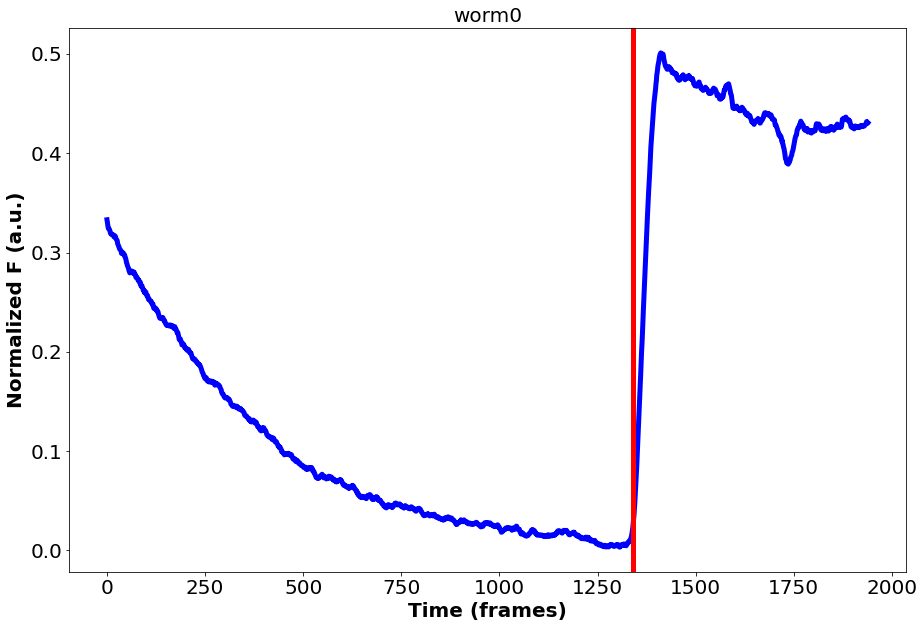

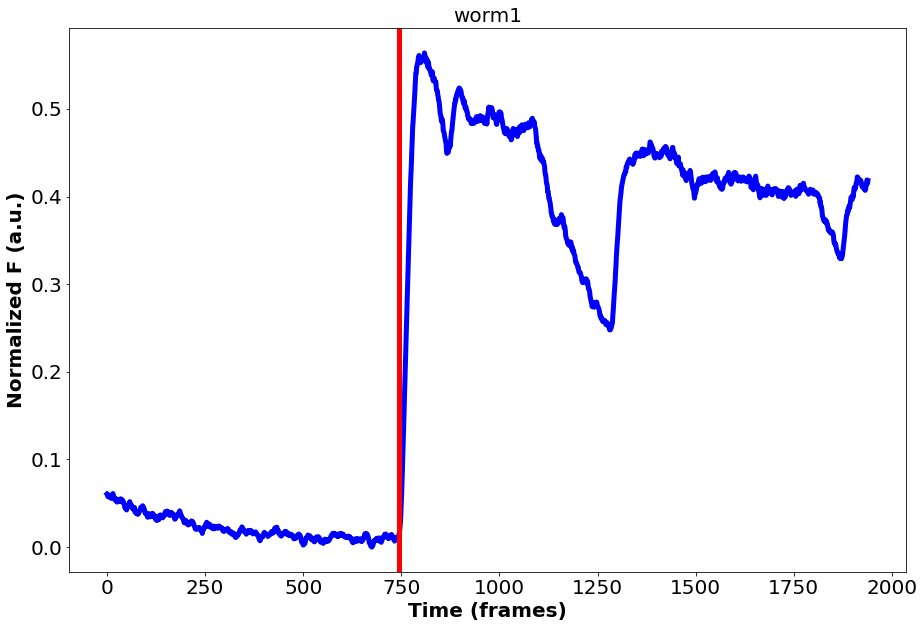

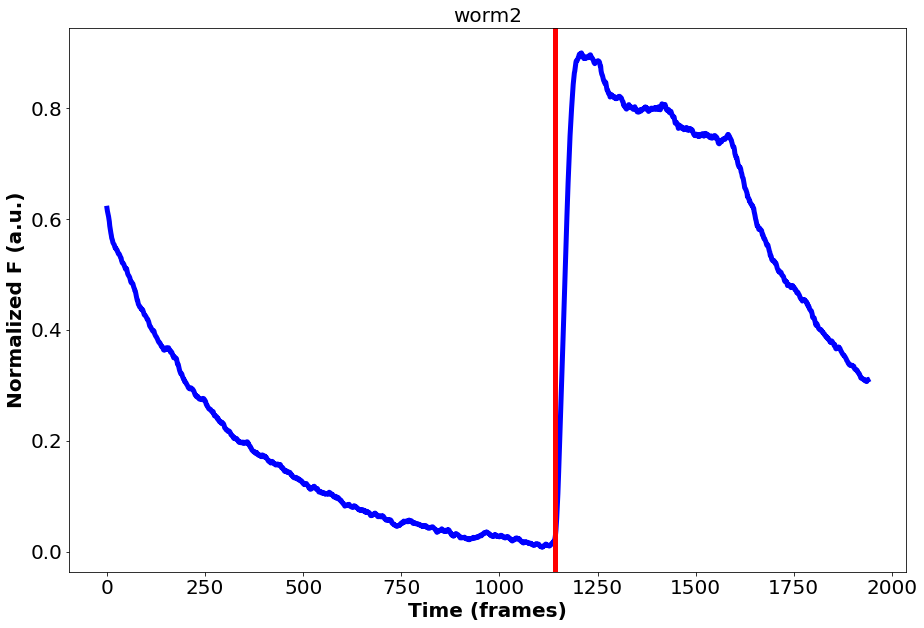

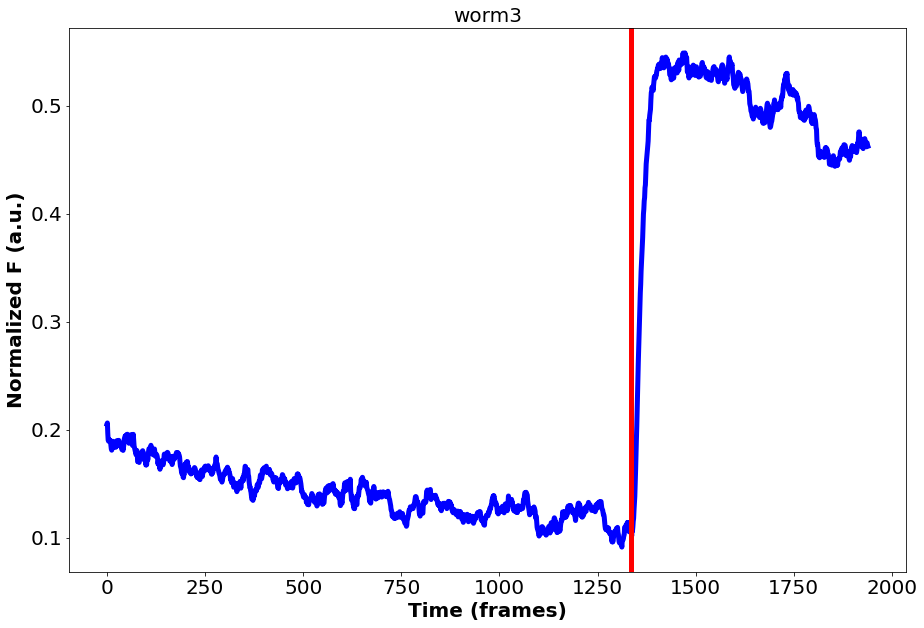

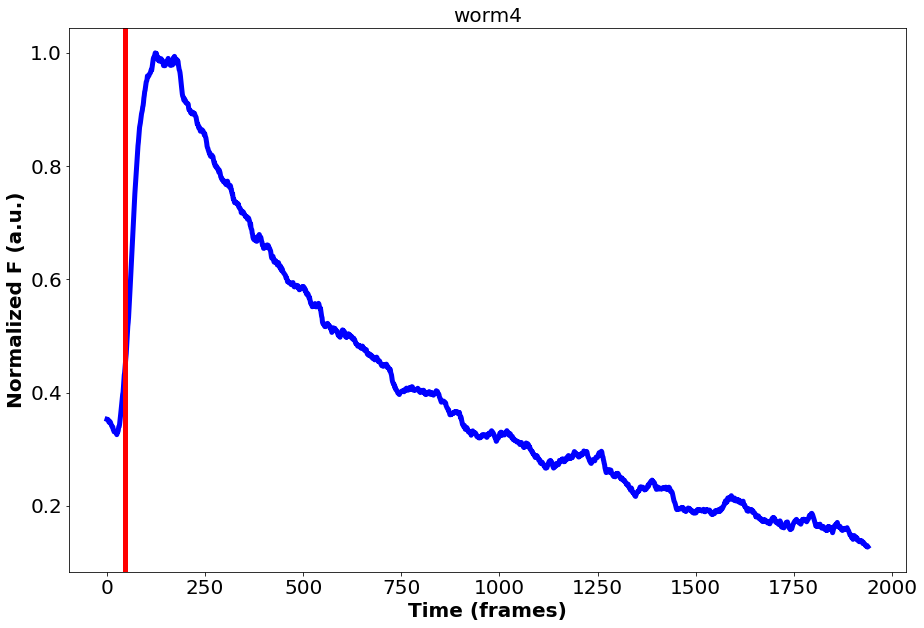

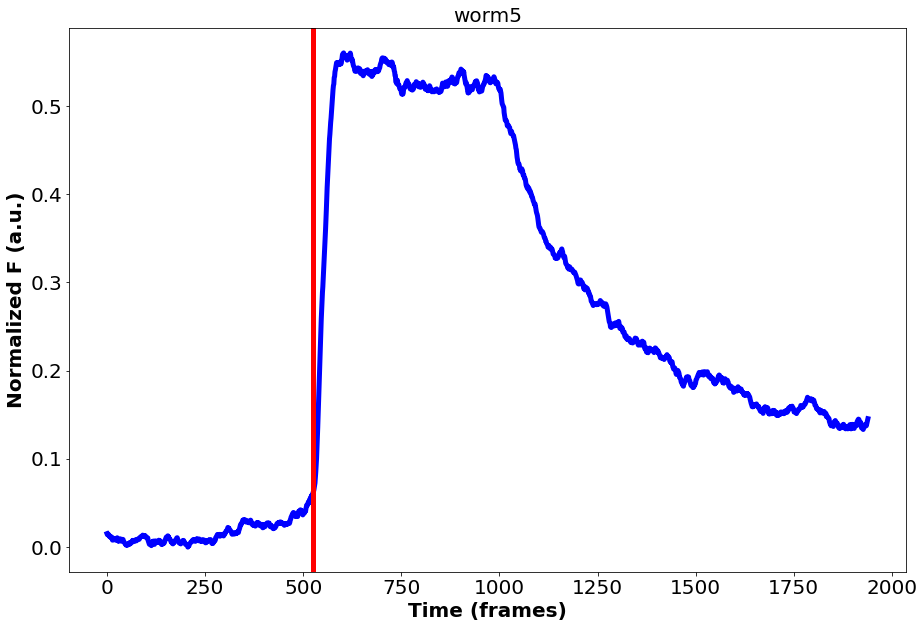

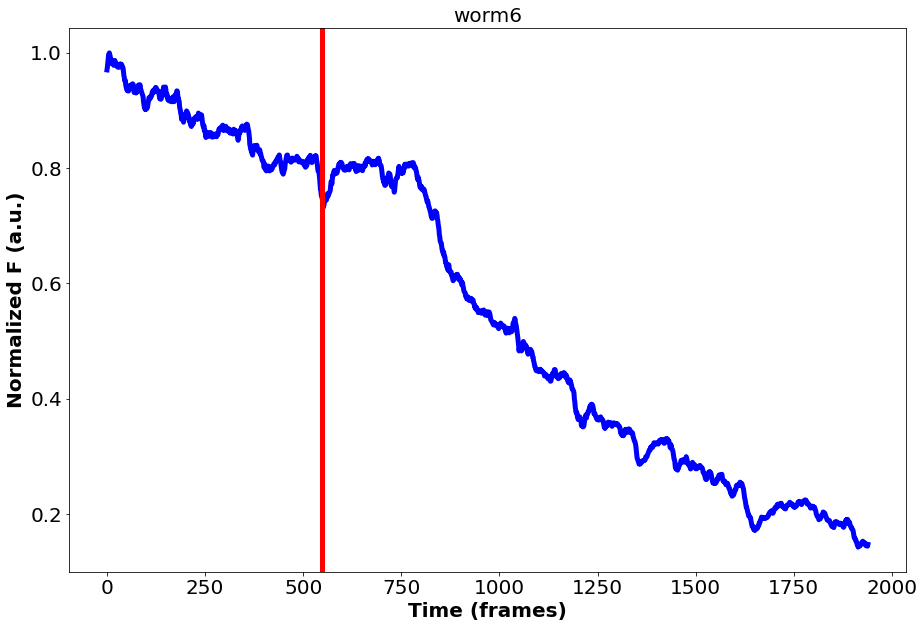

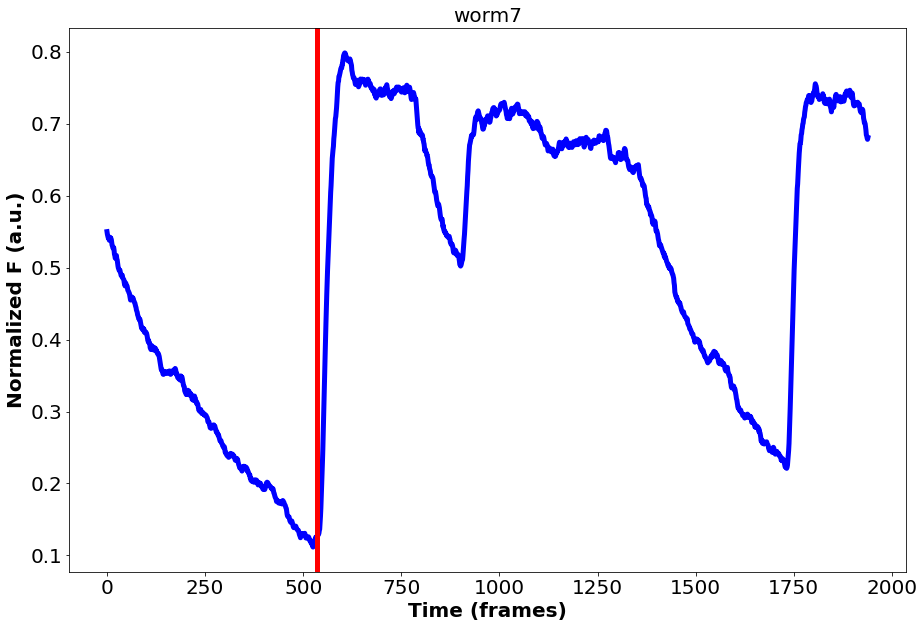

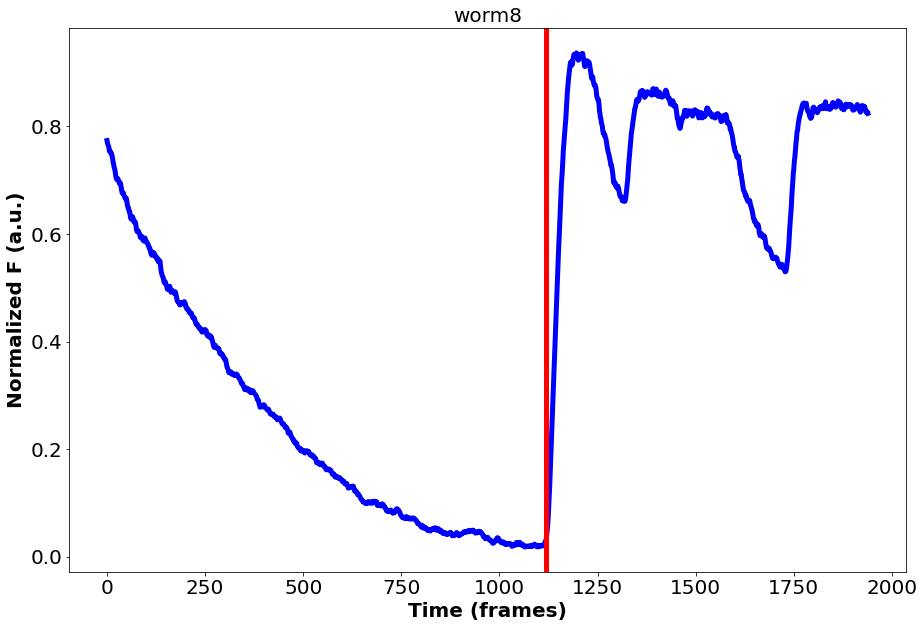

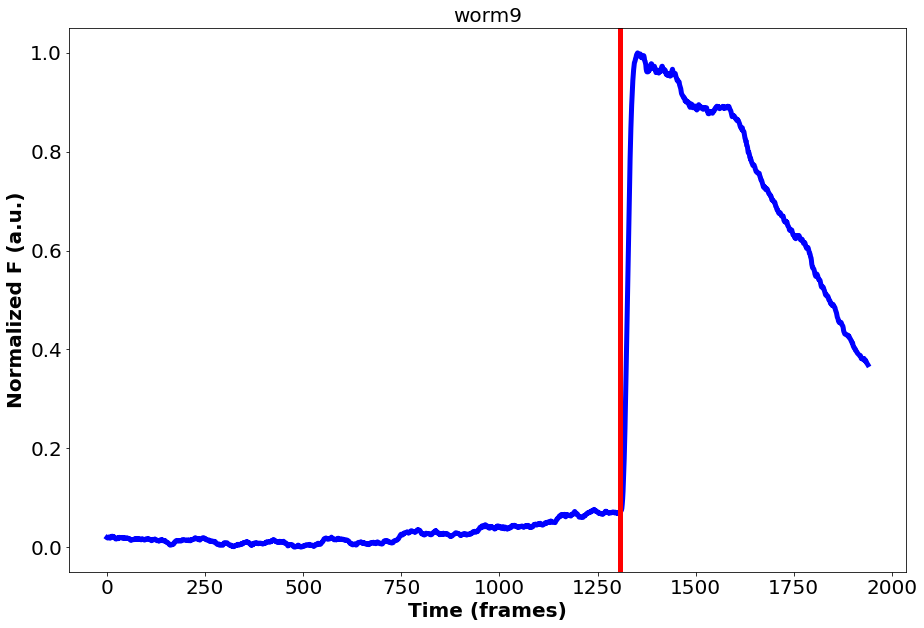

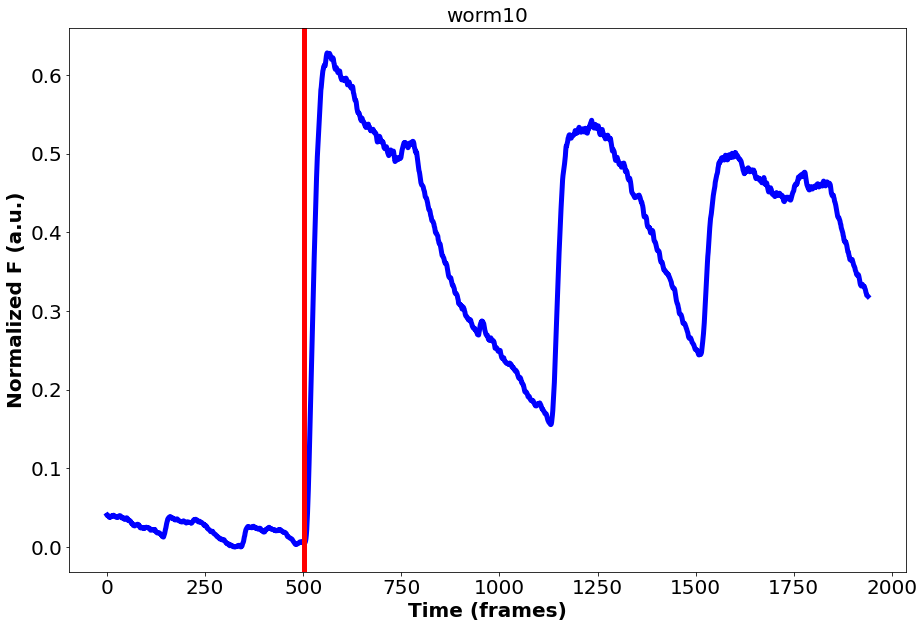

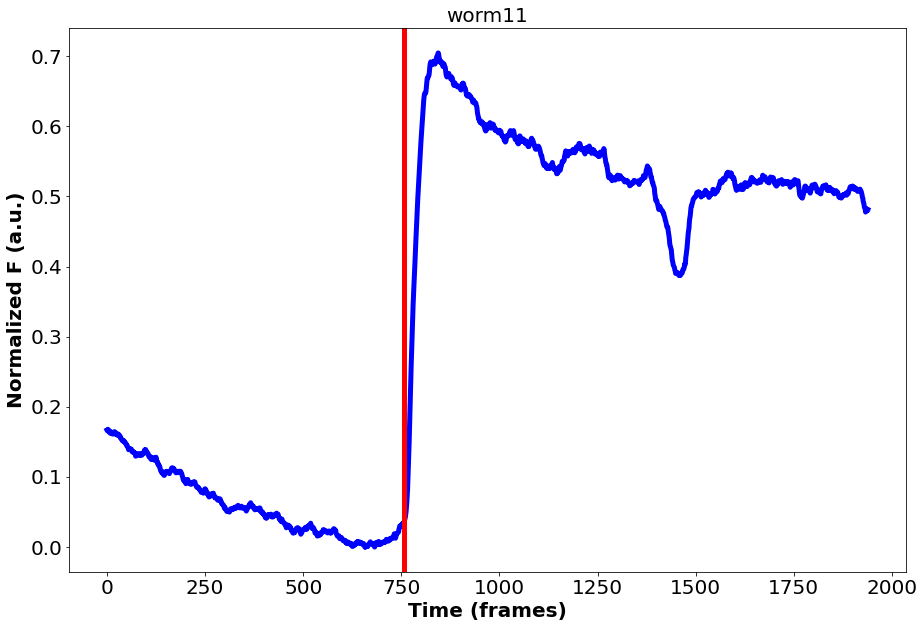

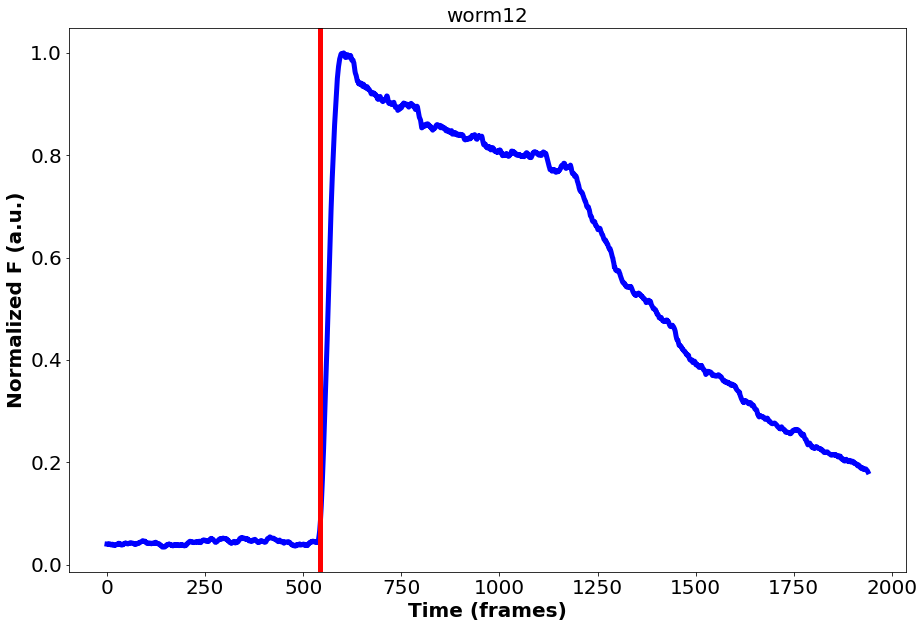

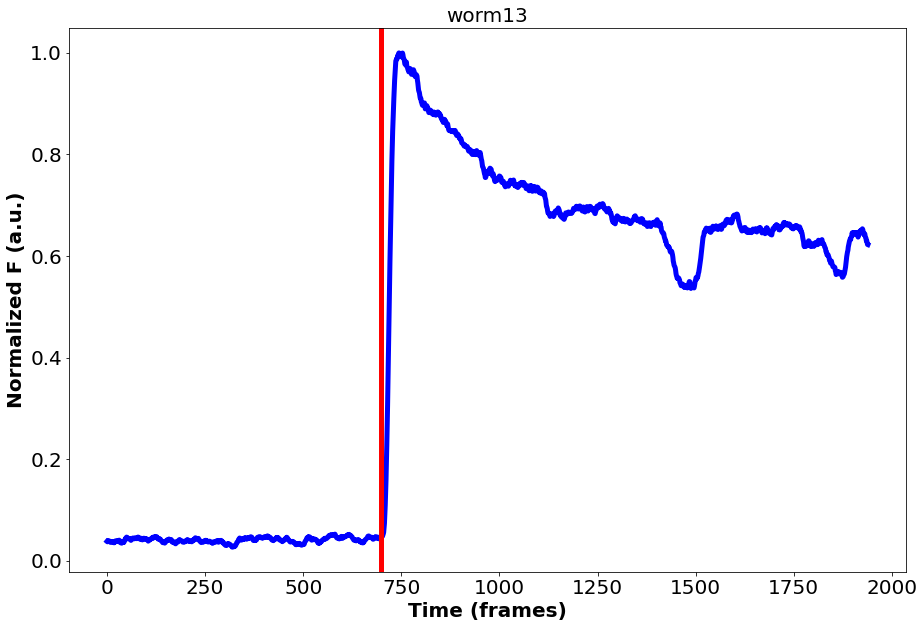

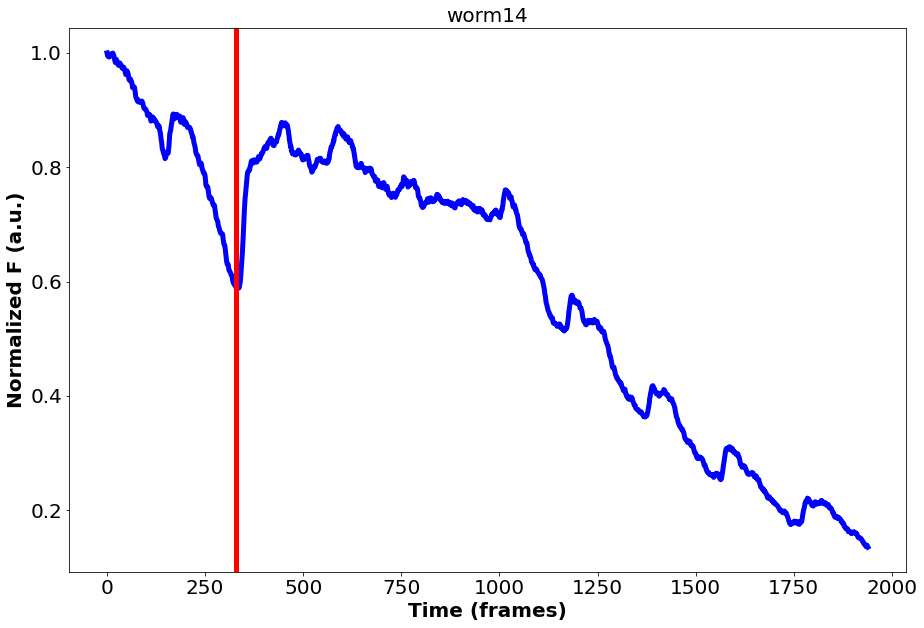

In [5]:
# Want to find onset time of AVA activity using dAVA/dt

onsets = []

for i in WT_dAVA_both:
    
    maxs = np.max(i)

    for j in range(len(i)):
        if i[j] == maxs:
            onsets.append(j-10) #subtract 10 to match times
print("Onset Times (frames)", onsets)

# Plot to double-check 
for a in range(WT_worm_num):
    fig, ax = plt.subplots(1,1, figsize=(15,10), facecolor='w')
    ax.set_title('worm' + str(a), fontsize=20)
    ax.plot(WT_AVA_both[a], color = 'blue', linewidth = 5)
    ax.axvline(x=onsets[a], color = 'red', linewidth = 5)
    ax.set_ylabel('Normalized F (a.u.)', fontsize=20, weight='bold')
    ax.set_xlabel('Time (frames)', fontsize=20, weight='bold') 
    # note this is frame numbers after normalization, not reflective of real time (not adjusted)
    # just want to plot out to make sure it works lol
    # real time would be time + 350
    ax.tick_params(axis= 'both', labelsize=20)
 

# Based on onset time, make respective AWC pulses during those times
AWC_pulses_all = []

# Want to try intervals of 10 frames, or 1 sec (10 fps)
times = np.arange(-100, 110, 10)
print("Time intervals", times)

for o in range(WT_worm_num):
    temp = []
    start = onsets[o] - 100 # start = 100 frames before onset time
    if start < 0:
        print("AVA onset too early. Worm #",o) # check if AVA activity peak is in beginning of trace
    end = onsets[o] + 100 # end = 100 frames after onset time
    
    for m in times: # loop through each time interval (10 frames, or 1 sec)
        empty = np.zeros(len(WT_AWC_both_avg)) # make empty array to fill AWC pulses in
        if start < 0:
            temp.append(empty) # if too early, just keep empty
            continue
        else:
            empty[start+m:end+m] = WT_AWC_both_avg[1650:1850] # this is a specific AWC pulse I isolated
            # this AWC pulse was chosen because it was the largest in amplitude
        temp.append(empty) # append time-locked AWC pulses relative to AVA onsets
    AWC_pulses_all.append(temp) # append to make matrix for each trace for each time interval
    


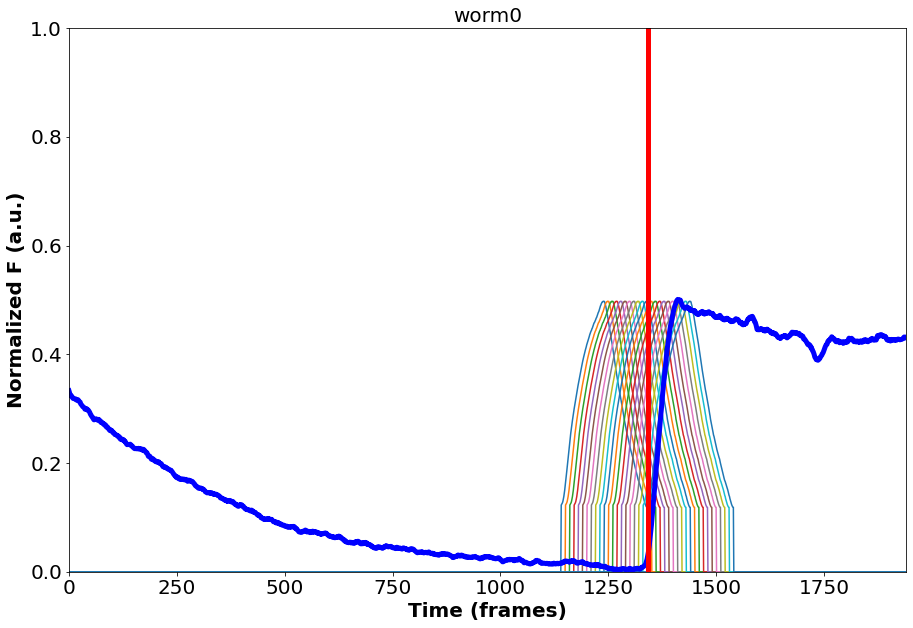

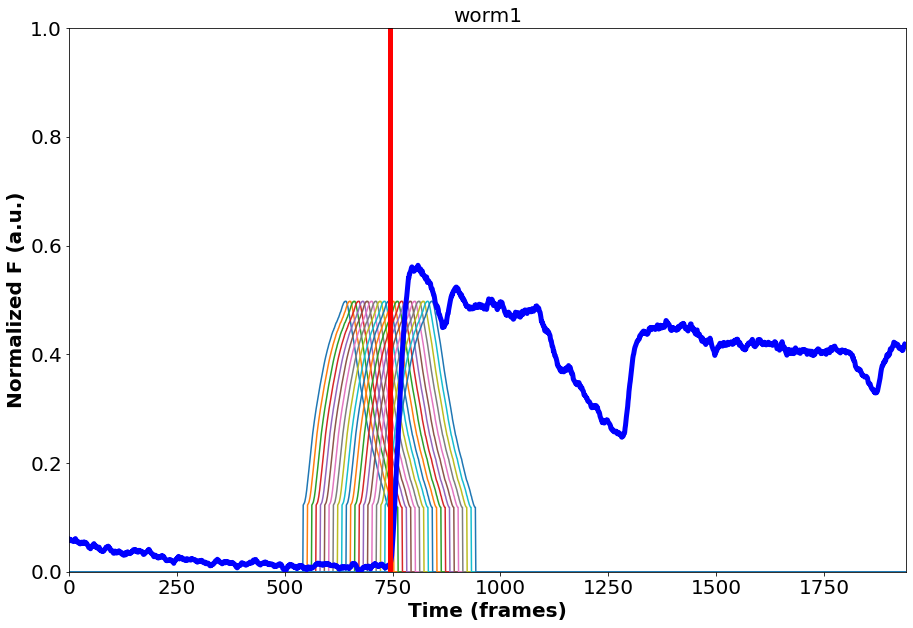

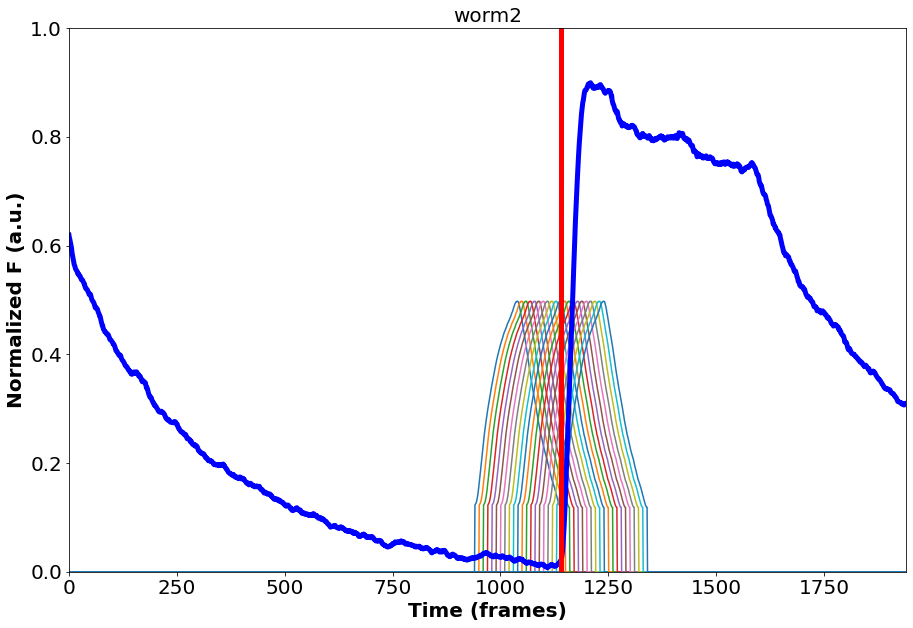

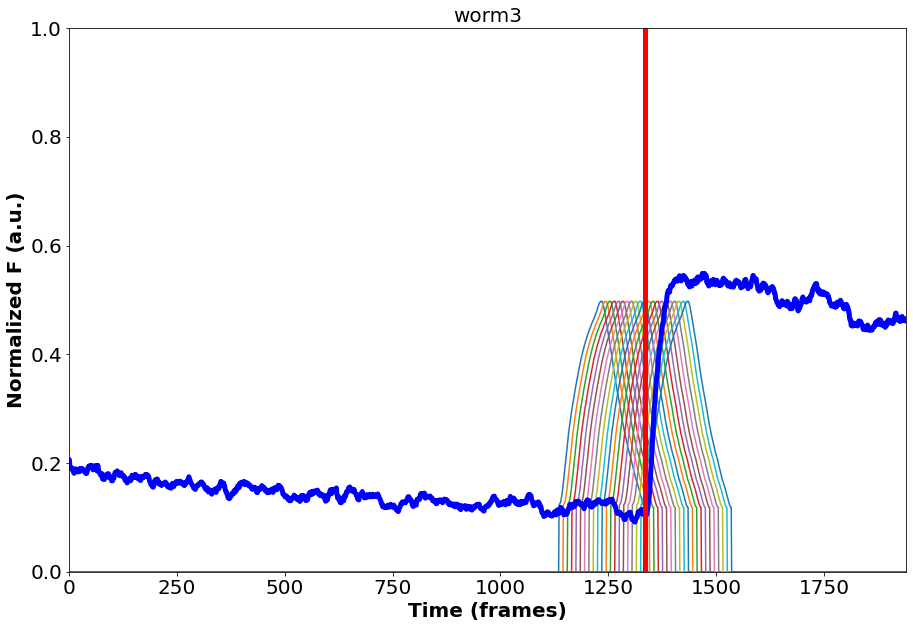

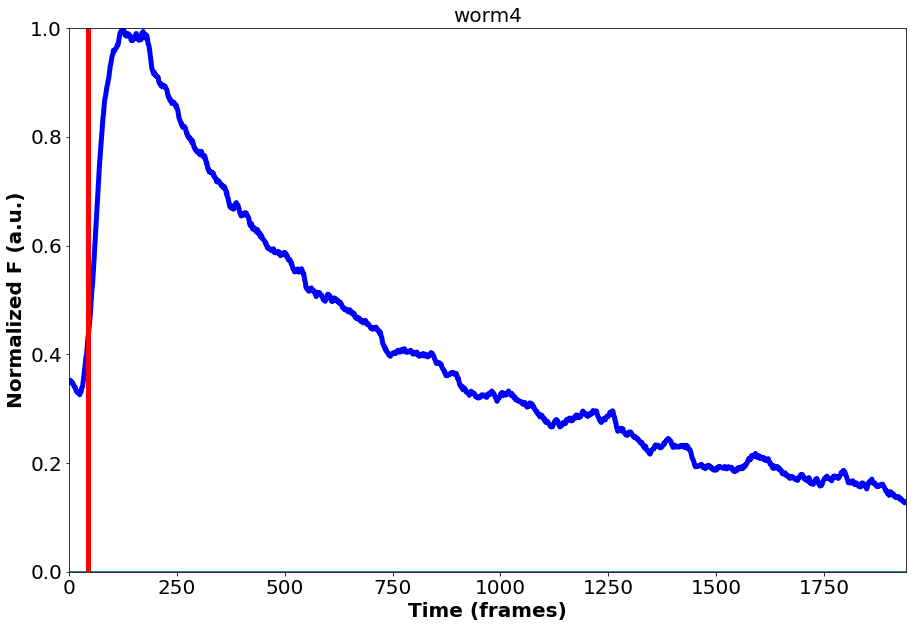

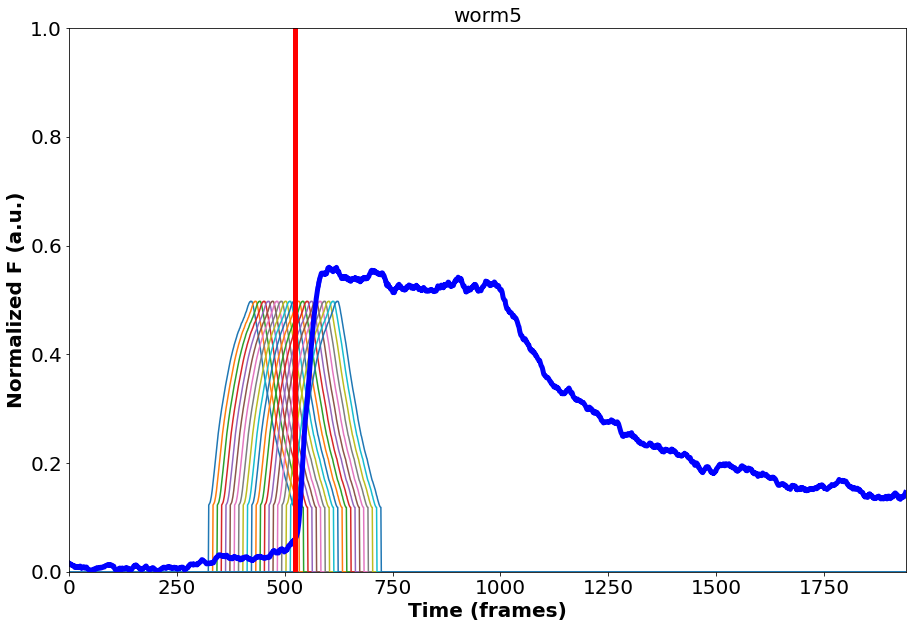

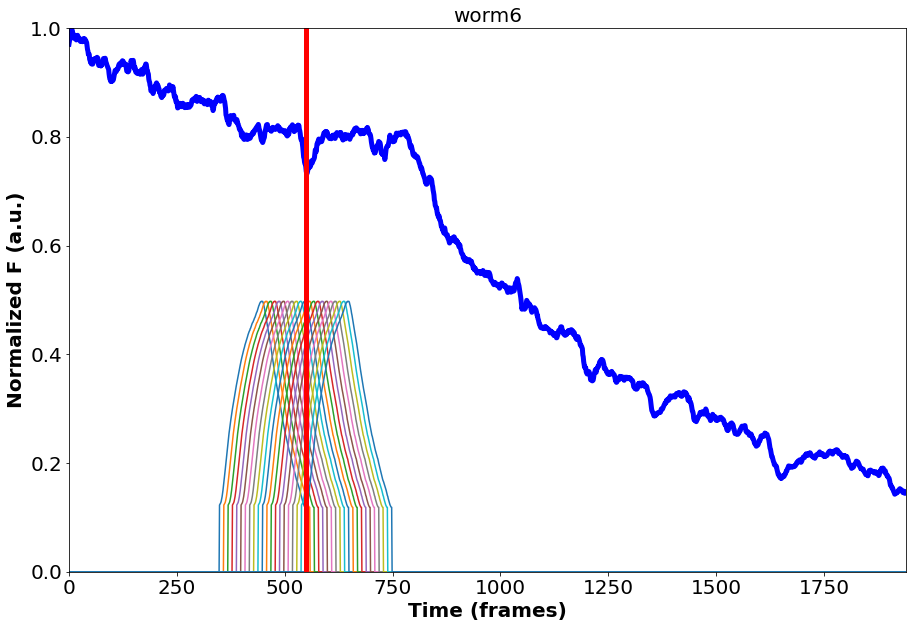

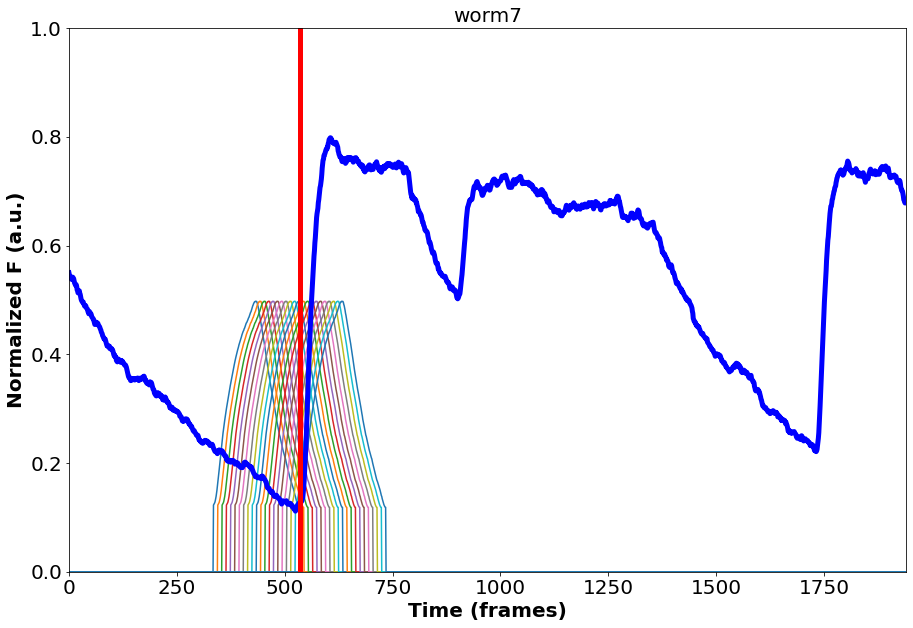

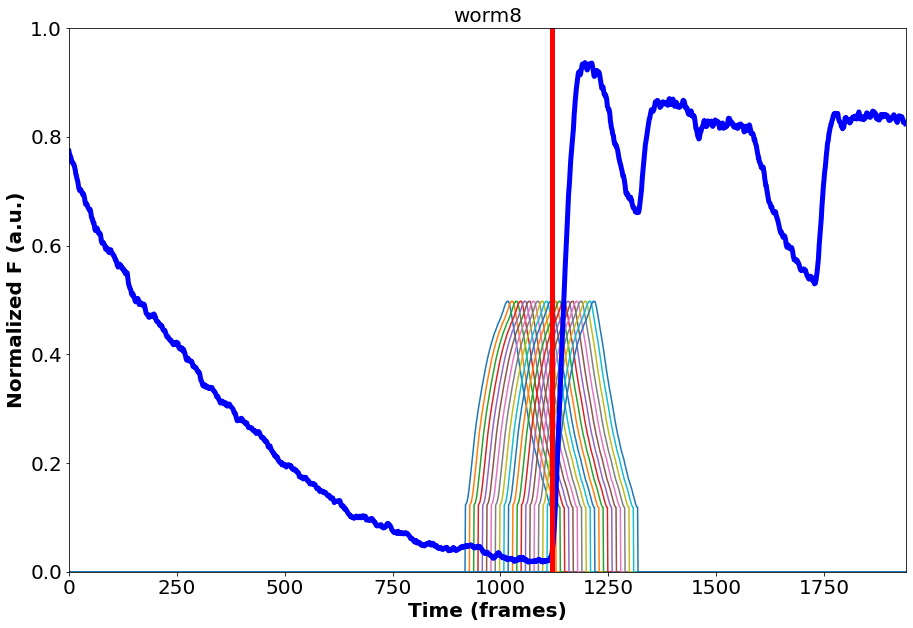

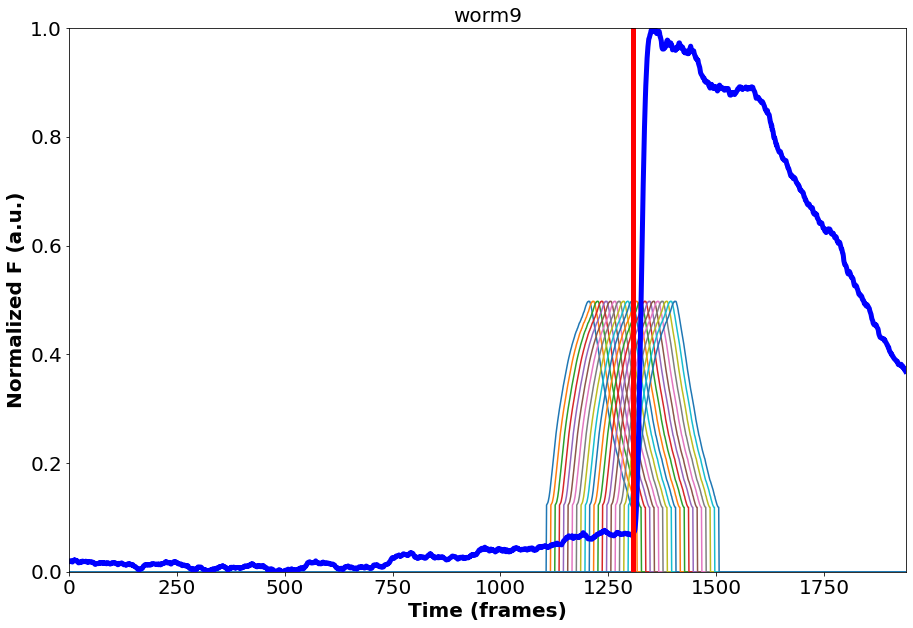

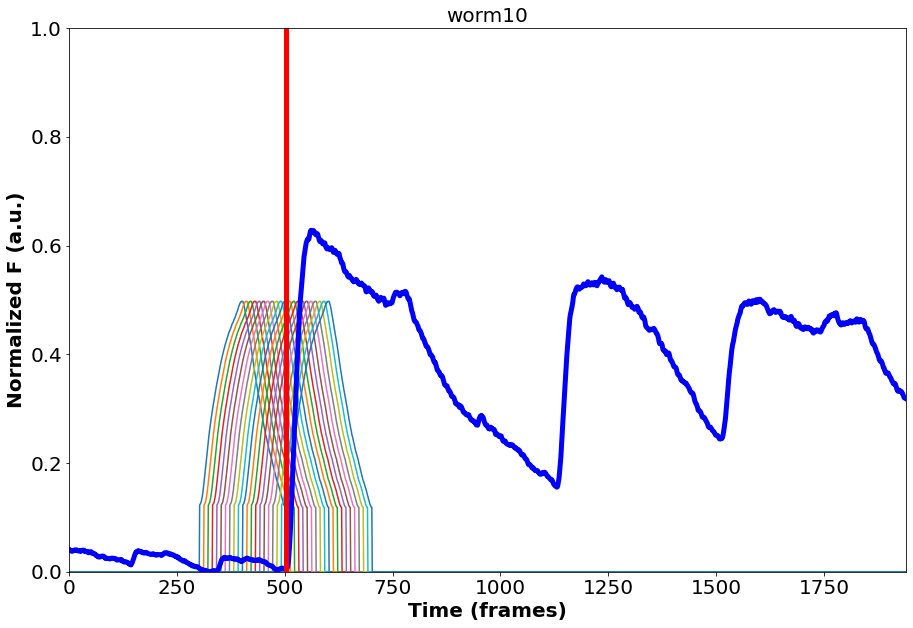

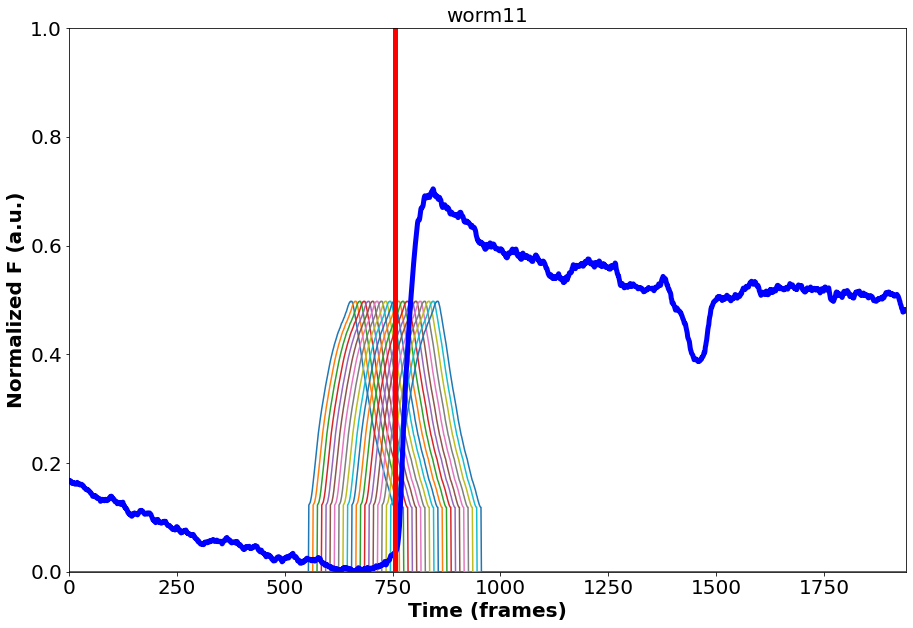

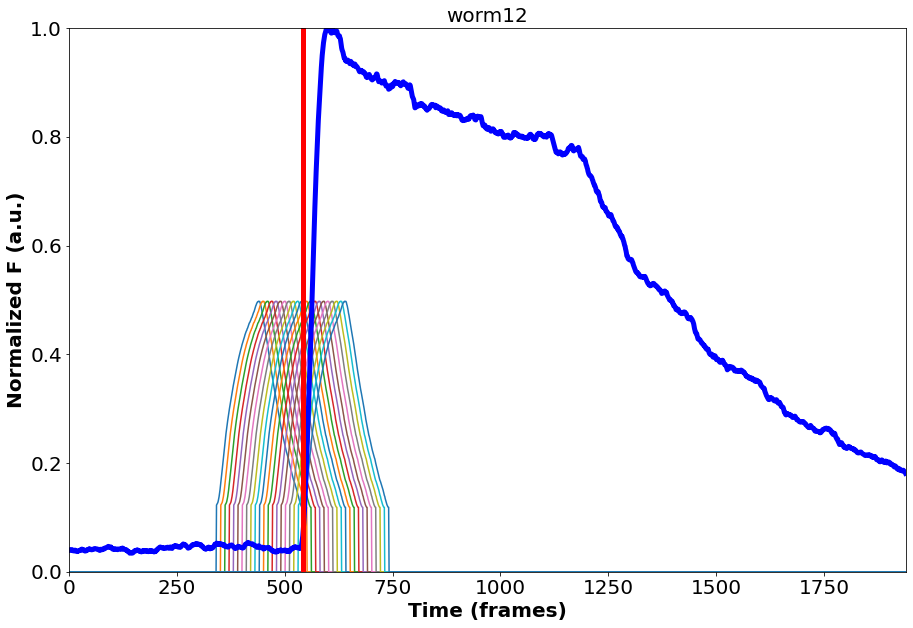

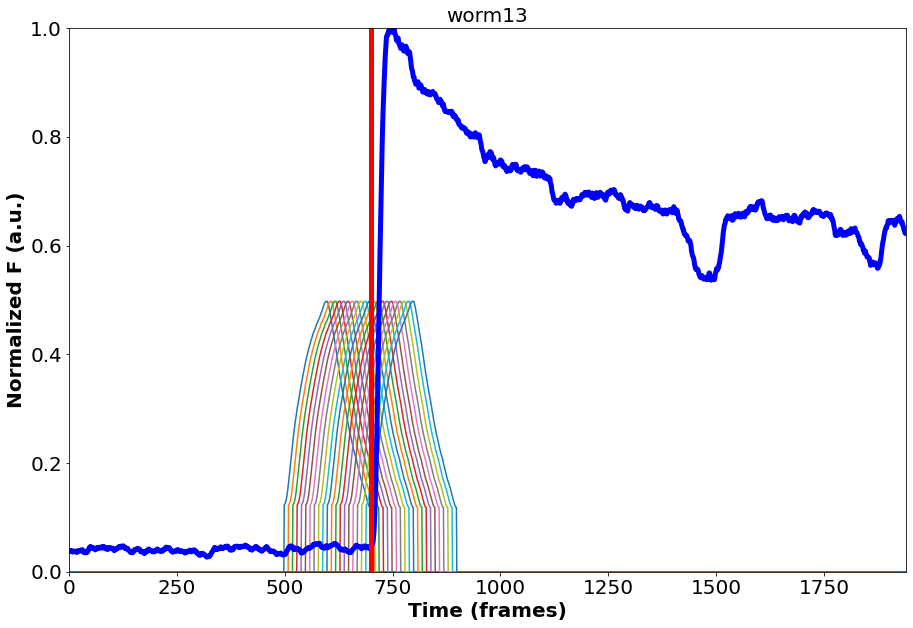

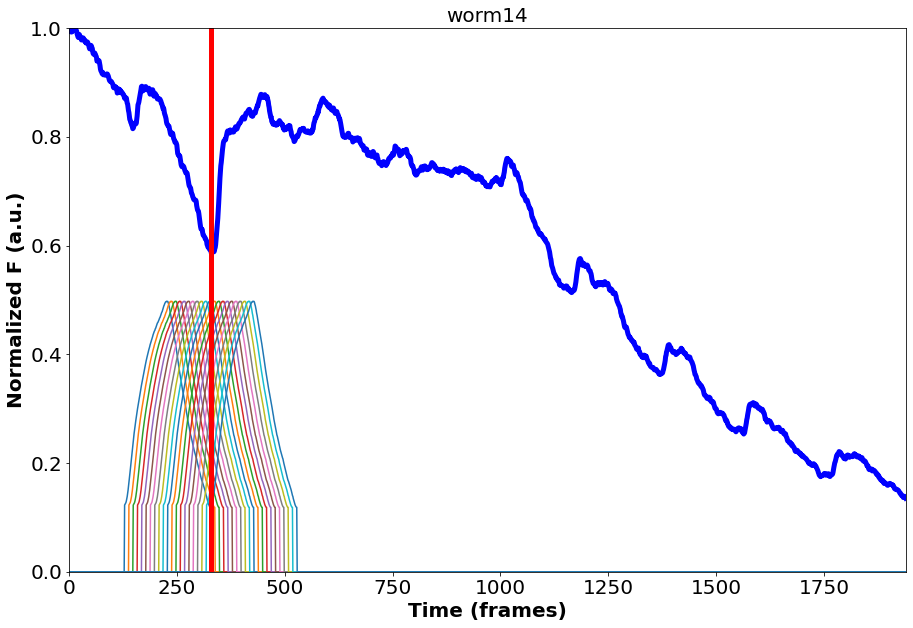

In [6]:
## Run this block to plot AWC pulses relative to AVA onset ##

for i in range(WT_worm_num):
    fig, ax = plt.subplots(1,1, figsize=(15,10), facecolor='w') 
    ax.set_title('worm' + str(i), fontsize=20)
    for pulses in AWC_pulses_all[i]:
        ax.plot(pulses)
    ax.plot(WT_AVA_both[i], color = 'blue', linewidth = 5)
    ax.axvline(x=onsets[i], color = 'red', linewidth = 5)
    ax.set_xlim([0,1940])
    ax.set_ylim([0,1])
    ax.set_ylabel('Normalized F (a.u.)', fontsize=20, weight='bold')
    ax.set_xlabel('Time (frames)', fontsize=20, weight='bold')  
    # note this is frame numbers after normalization, not reflective of real time (not adjusted)
    # just want to plot out to make sure it works lol
    # real time would be time + 350 (in frames, divide by 10 for seconds)
    ax.tick_params(axis= 'both', labelsize=20)

(15, 21, 1691)


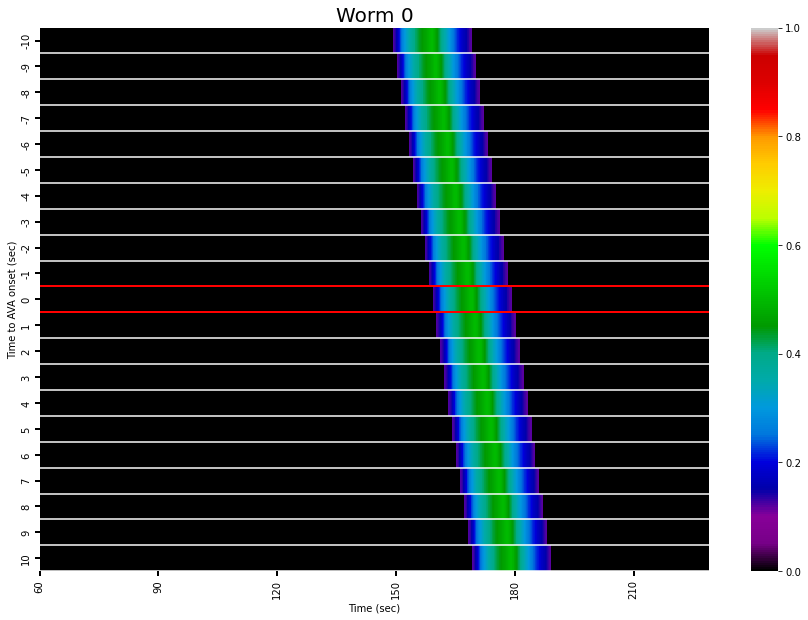

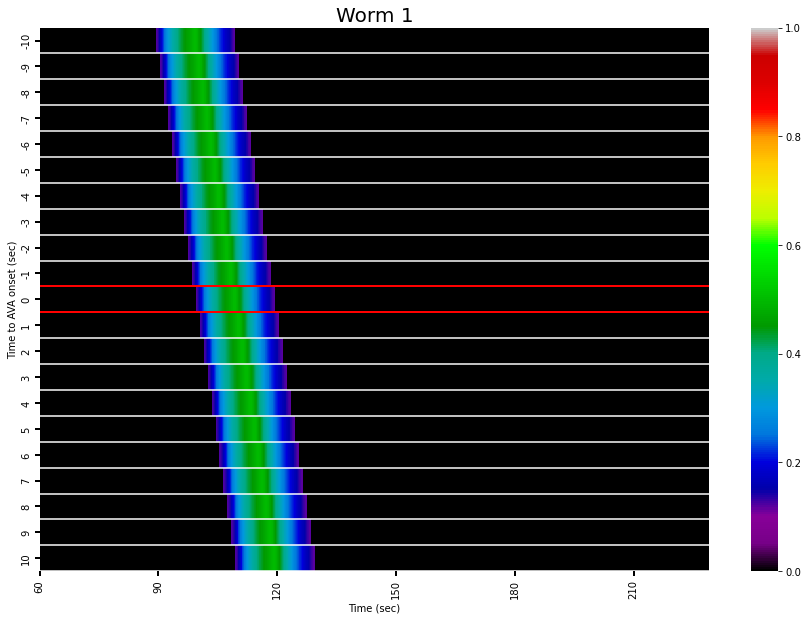

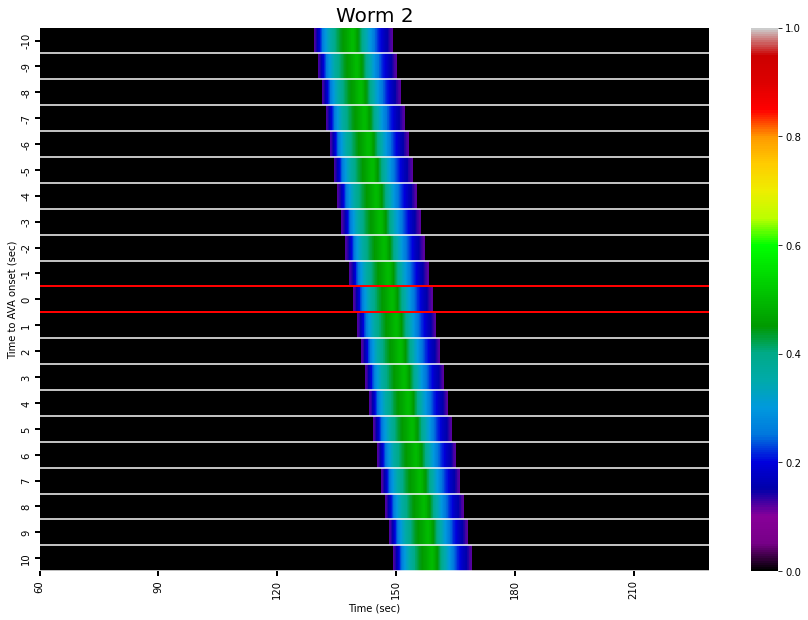

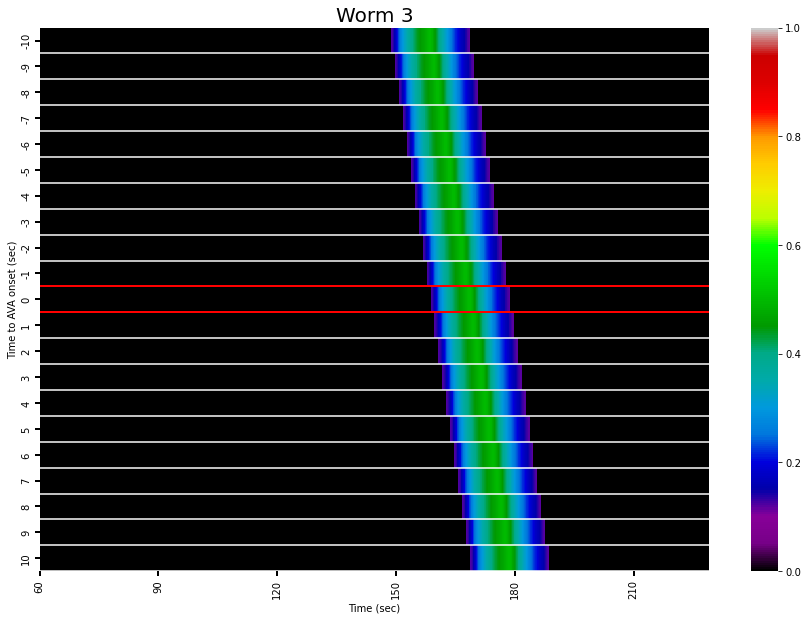

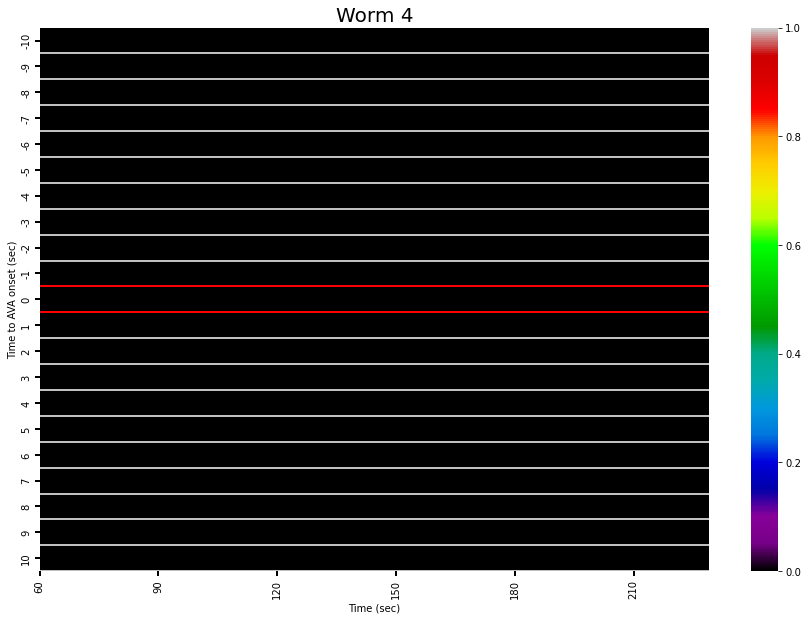

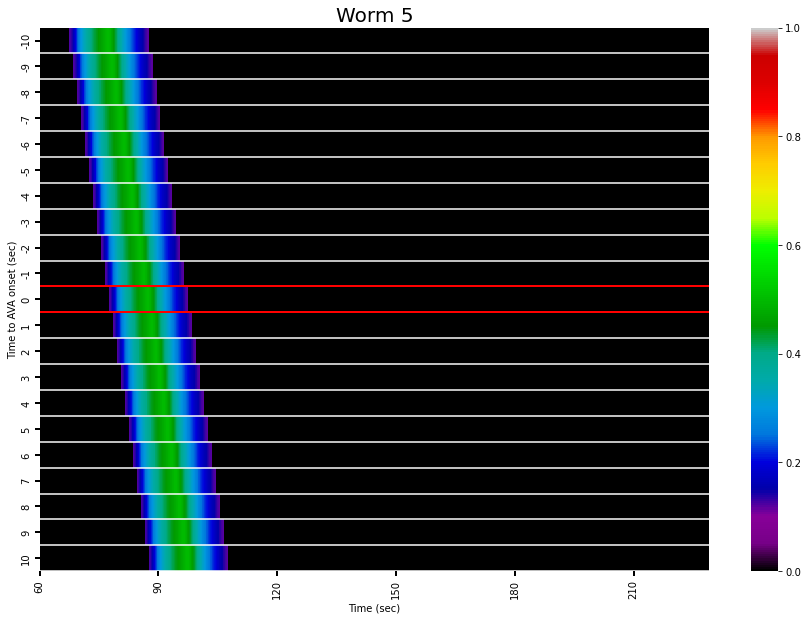

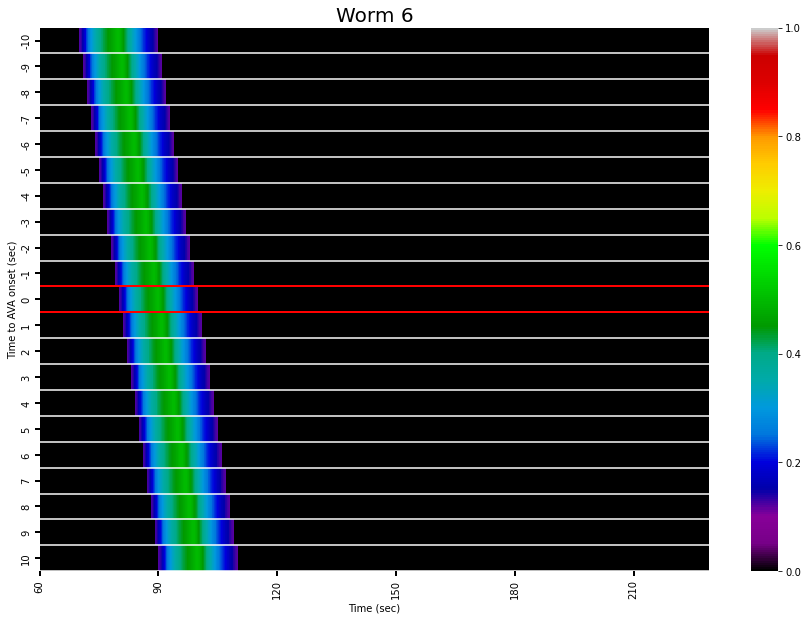

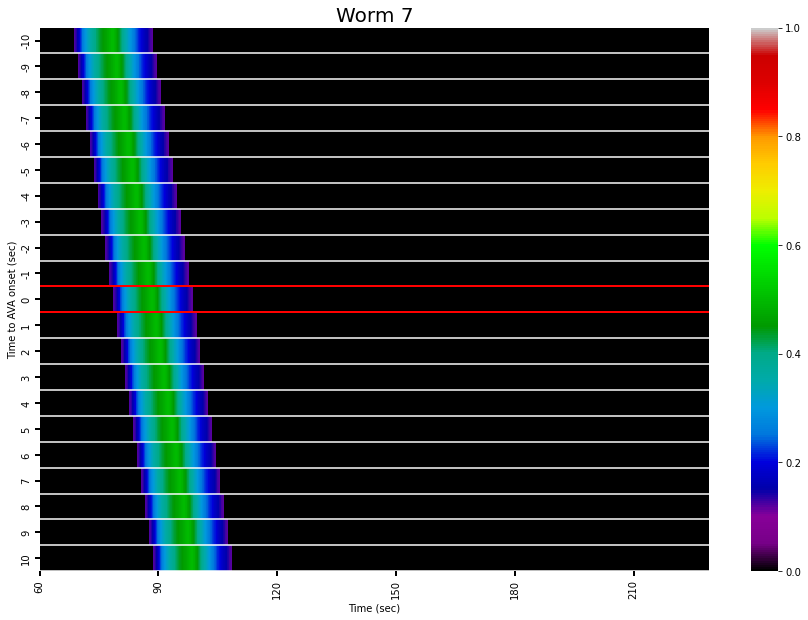

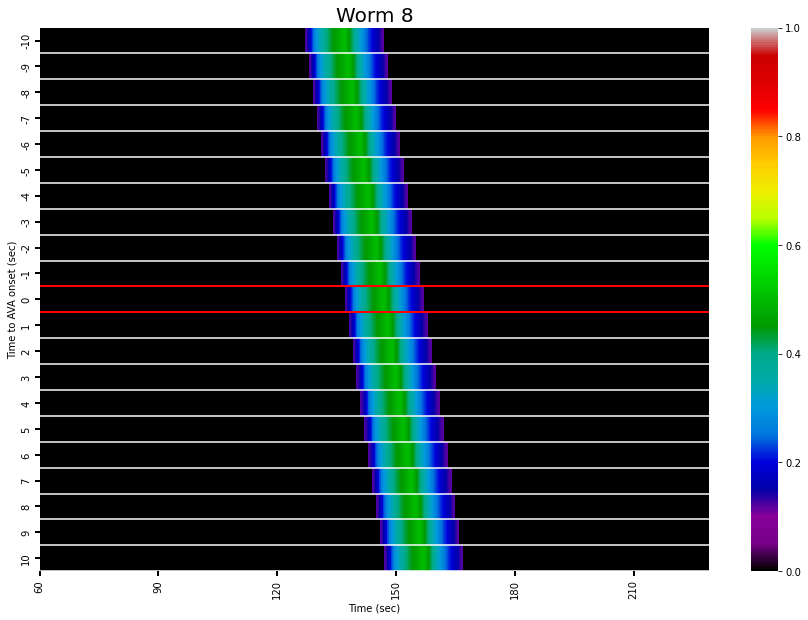

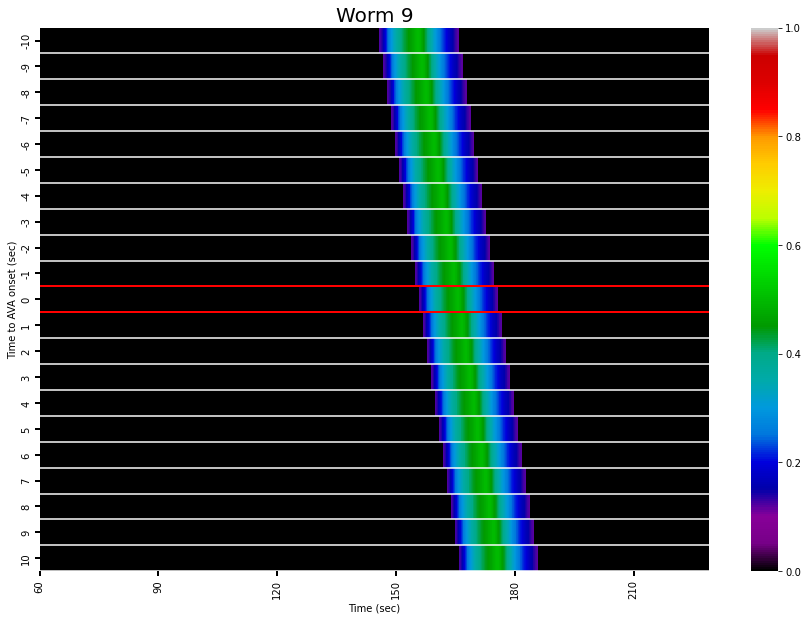

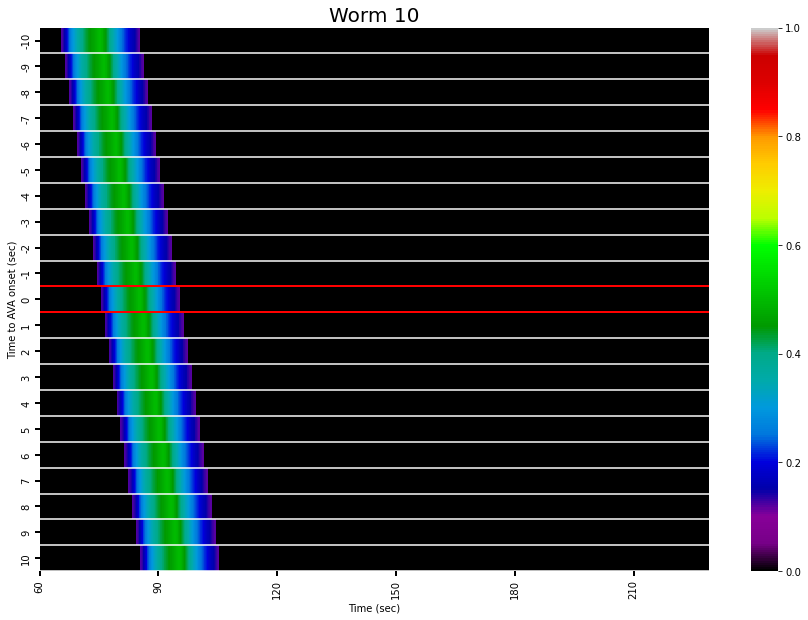

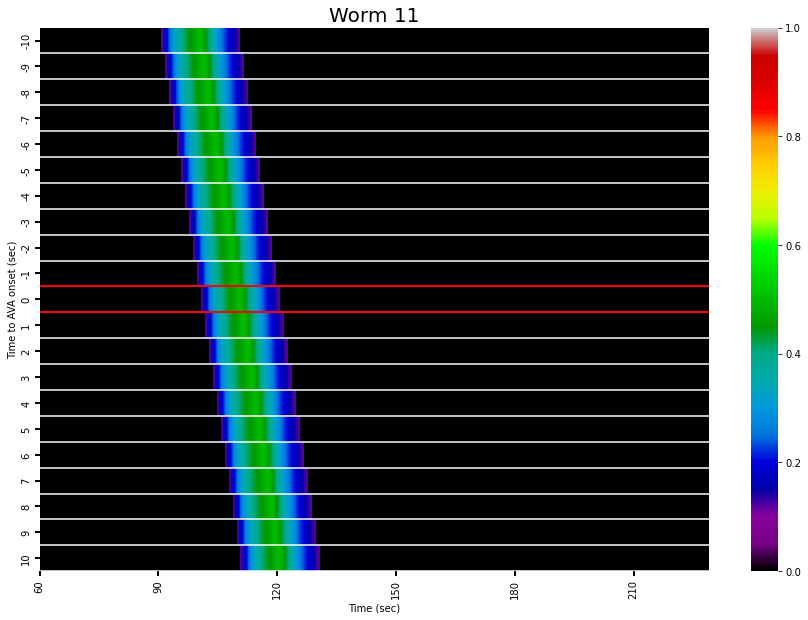

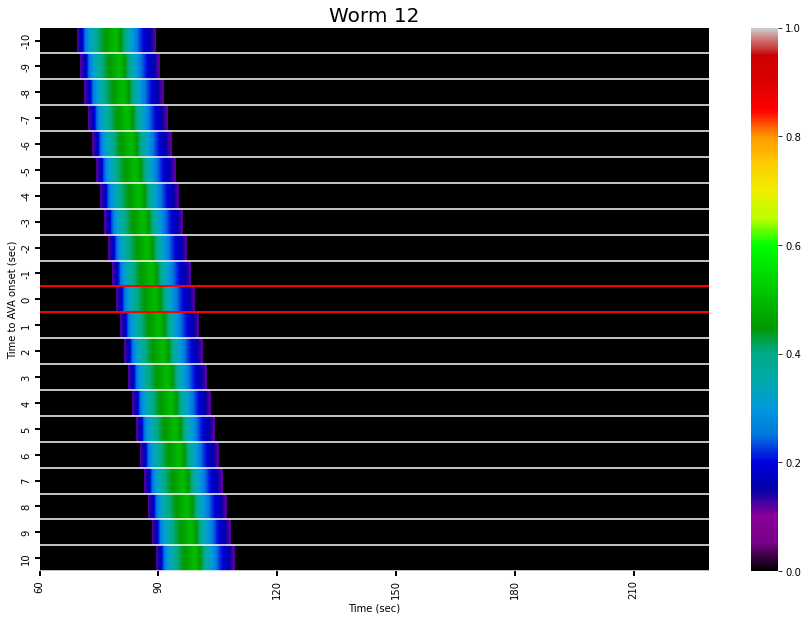

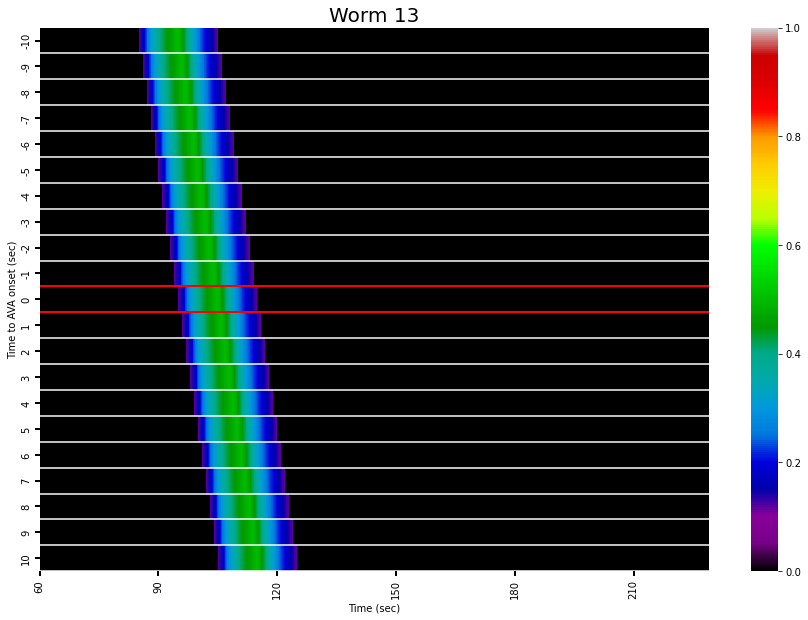

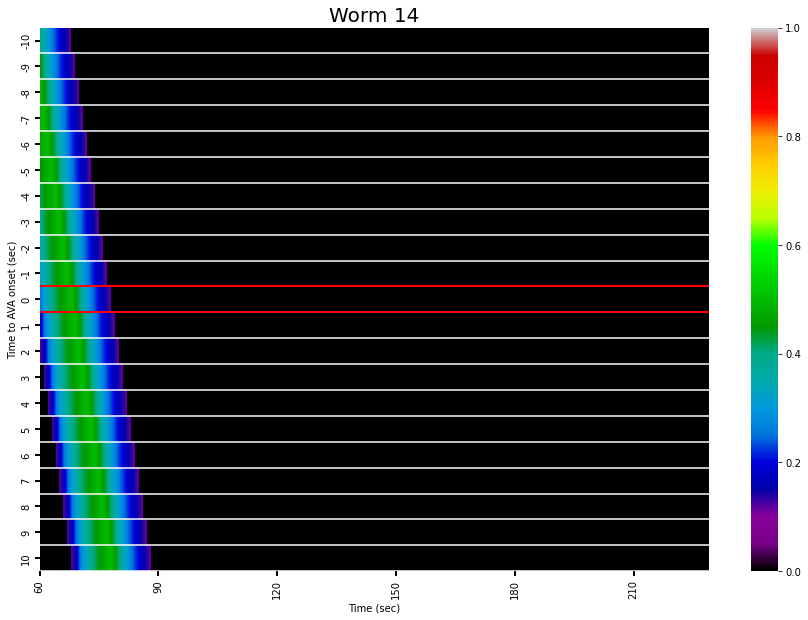

In [7]:
## Plot heatmap of AWC pulses ##

cut_AWC = []
for i in range(WT_worm_num):
    temp = []
    for a in AWC_pulses_all[i]:
        temp.append(a[249:]) 
        # need to match times to model, 
        # which gets truncated by 249 frames
    cut_AWC.append(temp)
    
print(np.shape(cut_AWC))

times_labels =[] # for y-axis, showing time shift intervals
# times are in frames, want to convert to seconds for plotting
for i in times:
    sec = i/10
    new = str(sec)
    times_labels.append(new[:-2])
    
sec_labels = ['60', '90', '120', '150', '180', '210']
# note these are times after modeling truncations, explained in previous notebooks 
# for x-axis, labeling time in seconds instead of frames
# I have to manually type out the time labels, having a weird issue with labeling the x-axis; 
# maybe you can figure out a better way lol :)

# note for the paper, I have the times labeled relative to AVA onset, 
# which I manually changed in Adobe
# Also, worm #2 is what's displayed in paper


for w in range(WT_worm_num):
    fig, ax = plt.subplots(1,1, figsize=(15,10), facecolor='w')
    ax.set_title('Worm ' + str(w), fontsize=20)
    sns.heatmap(cut_AWC[w], cmap = 'nipy_spectral', vmin=0, vmax=1)
    ax.hlines(np.arange(1,len(times)+1,1), *ax.get_xlim(), color='white') # want to put lines to separate traces
    ax.hlines([10,11], *ax.get_xlim(), color='red', linewidth=2) # highlight time=0 in red
    ax.set_yticklabels(times_labels)
    ax.set_xticks(np.arange(0,1800,300))
    ax.set_xticklabels(sec_labels)
    ax.tick_params(axis= 'both', labelsize=10, length=5, width=2)
    ax.set(xlabel="Time (sec)", ylabel="Time to AVA onset (sec)") 
    # note this is time after normalization and modeling, and is reflective of real time
    #plt.savefig('AWC Pulses - heatmap.svg')

In [8]:
# This is the same convolution for summing inputs as the 'Modeling Neuron Data - Summation.ipynb' notebook, 
# but this is modified to loop one worm at a time. 
# I needed to do this so that I could apply the different AWC pulses that are time-shifted.
# We will use the amplitudes that resulted from the summation model of the WT 'Full' data.
# We're not fitting, just applying the convolution to get modeled AIB.

def Convolution_Sum2(AVA, AWC, AVA_amp, AWC_amp): 
    time = 250
    t = np.arange(0, time)
    
    expo = (np.exp(-WT_AVA_only_params['Alpha1 Both']*t) - np.exp(-WT_AVA_only_params['Alpha2 Both']*t))

    kernel_AVA = AVA_amp * expo 
    kernel_AWC = AWC_amp * expo 
    
    model = np.convolve(AVA, kernel_AVA, 'valid') + np.convolve(AWC, kernel_AWC, 'valid') 

    return model


In [9]:
# Loop through all worms, and through all different AWC time-shifted pulses.

models_grid = np.empty((WT_worm_num, len(times), 1691)) # make an empty grid to store models
# 1691 is how many frames there end up being after modeling (I know this from previous models)


for i in range(WT_worm_num): # loop through worms
    for j in range(len(times)): # loop through each time interval
        if i == 4: # we know from above that worm #4 has AVA onset too early to make AWC time-shifted pulses
            models_grid[i][j] = [np.nan] * 1691 #just ignore this and fill with nans for worm #4
        else:
            convolved = Convolution_Sum2(WT_AVA_both[i], AWC_pulses_all[i][j], WT_sum_amps['AVA Amp'][i], WT_sum_amps['AWC Amp'][i])
            models_grid[i][j] = convolved # save models in their corresponding location 
        print('Worm', i,'Time interval', j, '/',str(len(times))) # printing to see progress

print('Done')

Worm 0 Time interval 0 / 21
Worm 0 Time interval 1 / 21
Worm 0 Time interval 2 / 21
Worm 0 Time interval 3 / 21
Worm 0 Time interval 4 / 21
Worm 0 Time interval 5 / 21
Worm 0 Time interval 6 / 21
Worm 0 Time interval 7 / 21
Worm 0 Time interval 8 / 21
Worm 0 Time interval 9 / 21
Worm 0 Time interval 10 / 21
Worm 0 Time interval 11 / 21
Worm 0 Time interval 12 / 21
Worm 0 Time interval 13 / 21
Worm 0 Time interval 14 / 21
Worm 0 Time interval 15 / 21
Worm 0 Time interval 16 / 21
Worm 0 Time interval 17 / 21
Worm 0 Time interval 18 / 21
Worm 0 Time interval 19 / 21
Worm 0 Time interval 20 / 21
Worm 1 Time interval 0 / 21
Worm 1 Time interval 1 / 21
Worm 1 Time interval 2 / 21
Worm 1 Time interval 3 / 21
Worm 1 Time interval 4 / 21
Worm 1 Time interval 5 / 21
Worm 1 Time interval 6 / 21
Worm 1 Time interval 7 / 21
Worm 1 Time interval 8 / 21
Worm 1 Time interval 9 / 21
Worm 1 Time interval 10 / 21
Worm 1 Time interval 11 / 21
Worm 1 Time interval 12 / 21
Worm 1 Time interval 13 / 21
Worm 

Worm 14 Time interval 7 / 21
Worm 14 Time interval 8 / 21
Worm 14 Time interval 9 / 21
Worm 14 Time interval 10 / 21
Worm 14 Time interval 11 / 21
Worm 14 Time interval 12 / 21
Worm 14 Time interval 13 / 21
Worm 14 Time interval 14 / 21
Worm 14 Time interval 15 / 21
Worm 14 Time interval 16 / 21
Worm 14 Time interval 17 / 21
Worm 14 Time interval 18 / 21
Worm 14 Time interval 19 / 21
Worm 14 Time interval 20 / 21
Done


In [10]:
# This is the same convolution as the 'Modeling Neuron Data - Derivative (Reversal-dependent).ipynb' notebook, 
# but this is modified to loop one worm at a time. 
# I needed to do this so that I could apply the different AWC pulses that are time-shifted.
# We will use the summation amplitudes for AVA from the WT 'Full' data (similar to how we model our derivative data)
# We will also use the amplitudes and offsets of AWC that resulted from the derivative model of the WT 'Full' data.
# We're not fitting, just applying the convolution to get modeled AIB.
# Just need to save the models for plotting heatmaps

def Convolution_dAVA2(AVA, AWC, dAVA, AVA_amp, AWC_amp, AWC_offset): 
    time = 250
    t = np.arange(0, time)

    expo = (np.exp(-WT_AVA_only_params['Alpha1 Both']*t) - np.exp(-WT_AVA_only_params['Alpha2 Both']*t))
    
    kernel_AVA = AVA_amp * expo
    
    kernel_AWC = AWC_amp * expo 
    dAVA_amp = np.convolve(dAVA, kernel_AWC, 'same') + AWC_offset

    model = (np.convolve(AVA[10:-10], kernel_AVA, 'valid')) + np.convolve(AWC[10:-10] * dAVA_amp, expo, 'valid') 

    return model


In [11]:
# Loop through all worms, and through all different AWC time-shifted pulses.

models_grid_dx = np.empty((WT_worm_num, len(times), 1671)) # make an empty grid to store models
# 1671 is how many frames there end up being after modeling (I know this from previous models)

for i in range(WT_worm_num): # loop through all worms
    for j in range(len(times)): # loop through each time interval
        if i == 4: # we know previously that worm #4's AVA onset is too early to have AWC pulses applied
            models_grid_dx[i][j] = [np.nan] * 1671 # so just fill with Nans to ignore
        else:
            convolved_dx = Convolution_dAVA2(WT_AVA_both[i], AWC_pulses_all[i][j], WT_dAVA_both[i],
                                             WT_sum_amps['AVA Amp'][i], WT_dx_params['AWC Amp'][i], 
                                             WT_dx_params['AWC Offset'][i]) 
            models_grid_dx[i][j] = convolved_dx # save models in proper locations
        print('Worm', i,'Time interval', j, '/',str(len(times))) # print out progress

print('Done')

Worm 0 Time interval 0 / 21
Worm 0 Time interval 1 / 21
Worm 0 Time interval 2 / 21
Worm 0 Time interval 3 / 21
Worm 0 Time interval 4 / 21
Worm 0 Time interval 5 / 21
Worm 0 Time interval 6 / 21
Worm 0 Time interval 7 / 21
Worm 0 Time interval 8 / 21
Worm 0 Time interval 9 / 21
Worm 0 Time interval 10 / 21
Worm 0 Time interval 11 / 21
Worm 0 Time interval 12 / 21
Worm 0 Time interval 13 / 21
Worm 0 Time interval 14 / 21
Worm 0 Time interval 15 / 21
Worm 0 Time interval 16 / 21
Worm 0 Time interval 17 / 21
Worm 0 Time interval 18 / 21
Worm 0 Time interval 19 / 21
Worm 0 Time interval 20 / 21
Worm 1 Time interval 0 / 21
Worm 1 Time interval 1 / 21
Worm 1 Time interval 2 / 21
Worm 1 Time interval 3 / 21
Worm 1 Time interval 4 / 21
Worm 1 Time interval 5 / 21
Worm 1 Time interval 6 / 21
Worm 1 Time interval 7 / 21
Worm 1 Time interval 8 / 21
Worm 1 Time interval 9 / 21
Worm 1 Time interval 10 / 21
Worm 1 Time interval 11 / 21
Worm 1 Time interval 12 / 21
Worm 1 Time interval 13 / 21
Worm 

In [15]:
# Even though our traces are normalized from 0-1, the resulting model can exceed that. 
# Here, you can see that the max exceeds 1 for the derivative model, so we'll re-normalize the heatmap for plotting 

# Just showing worm2 as an example
print('summation max', np.max(models_grid[2]))
print('derivative max', np.max(models_grid_dx[2]))


## - Re-Normalize - ##

# Normalization formula: (F - Fmin) / (Fmax - Fmin) where Fmin/max is the min/max for each worm

def Normalize(array, worms): 
#need to reshape normalize arrays by number of worms 

    norms = []
    
    for i in range(worms):
        temp = []
        mins = np.min(array[i]) 
        maxs = np.max(array[i]) 
        
        for f in array[i]:
            norm = (f - mins)/(maxs - mins) # apply normalization formula
            temp.append(norm)
        
        norms.append(temp)
        
    return norms

normalized_models_grid = Normalize(models_grid, WT_worm_num)
normalized_models_grid_dx = Normalize(models_grid_dx, WT_worm_num)



summation max 0.8241725431989919
derivative max 1.4184421431058611


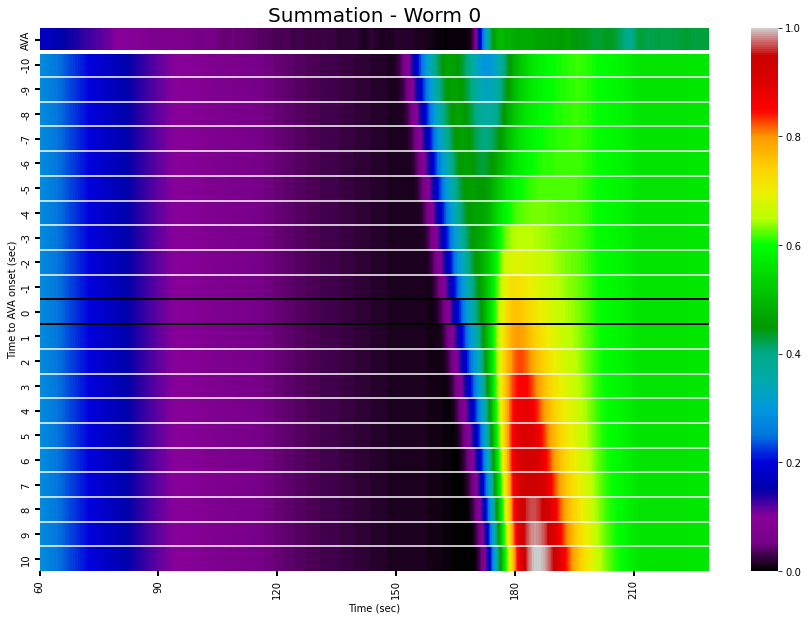

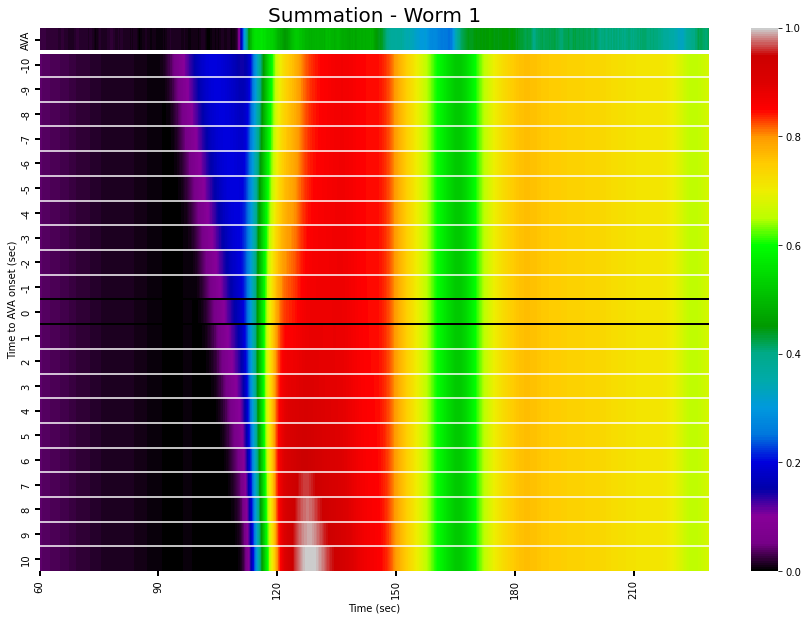

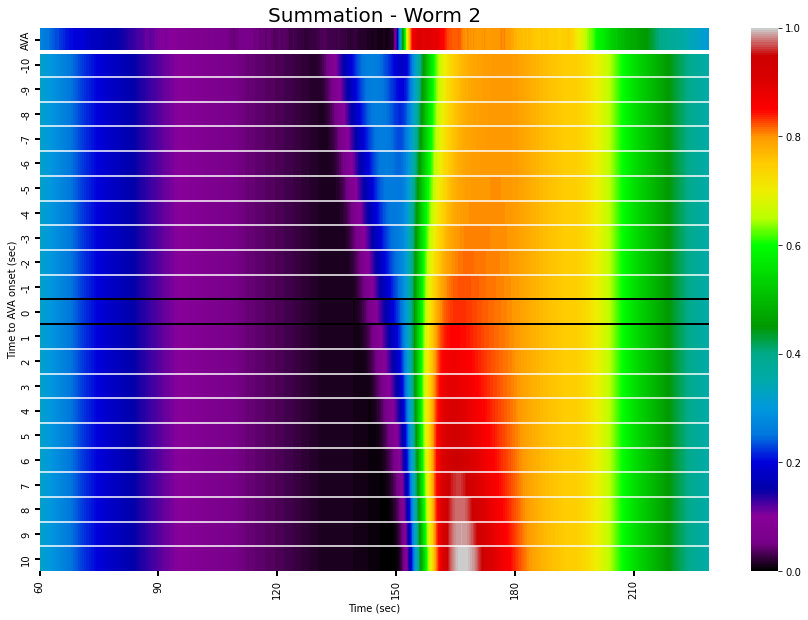

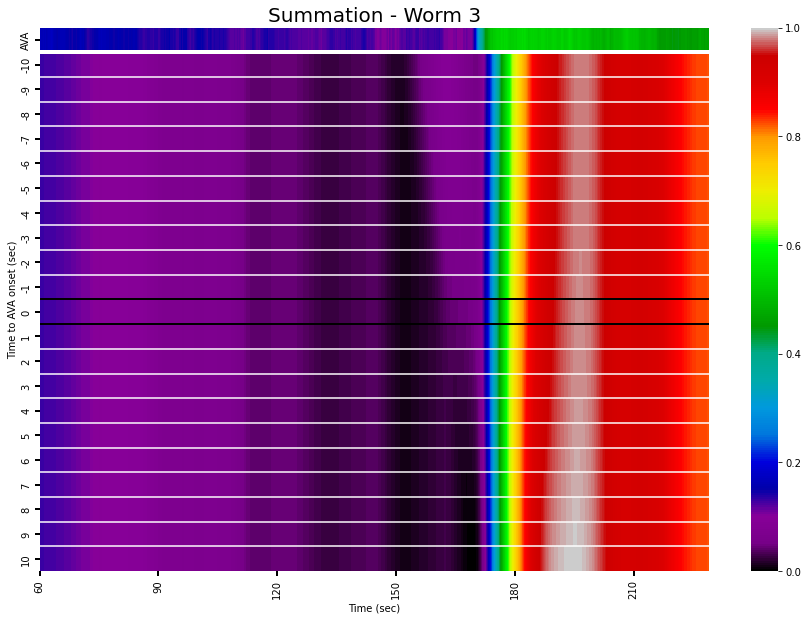

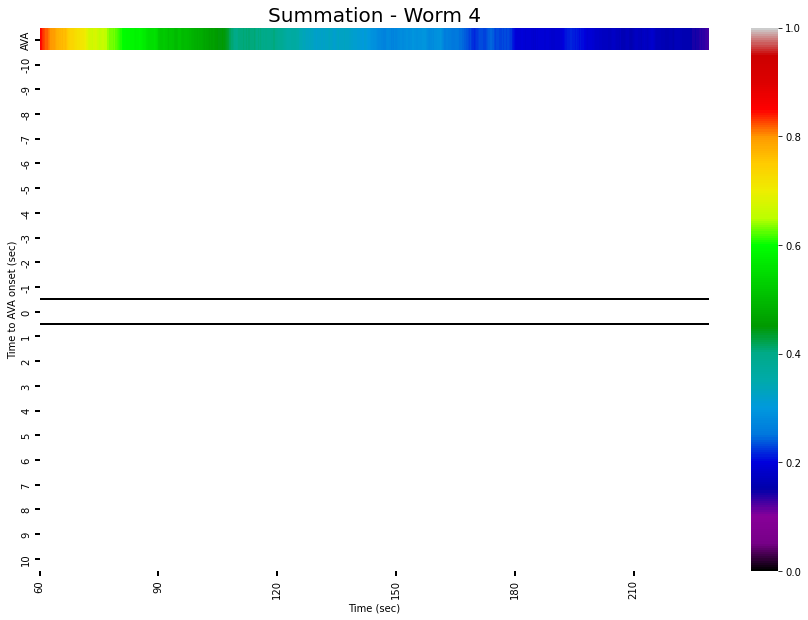

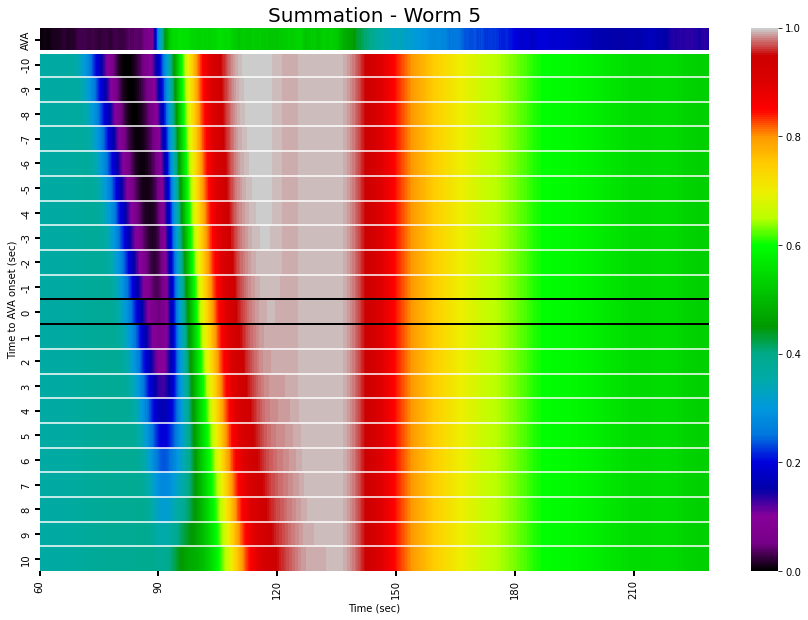

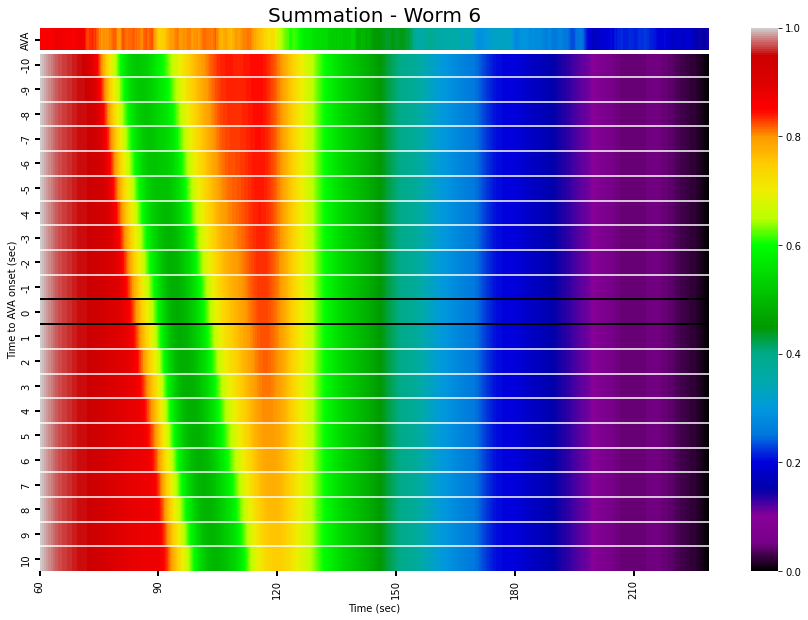

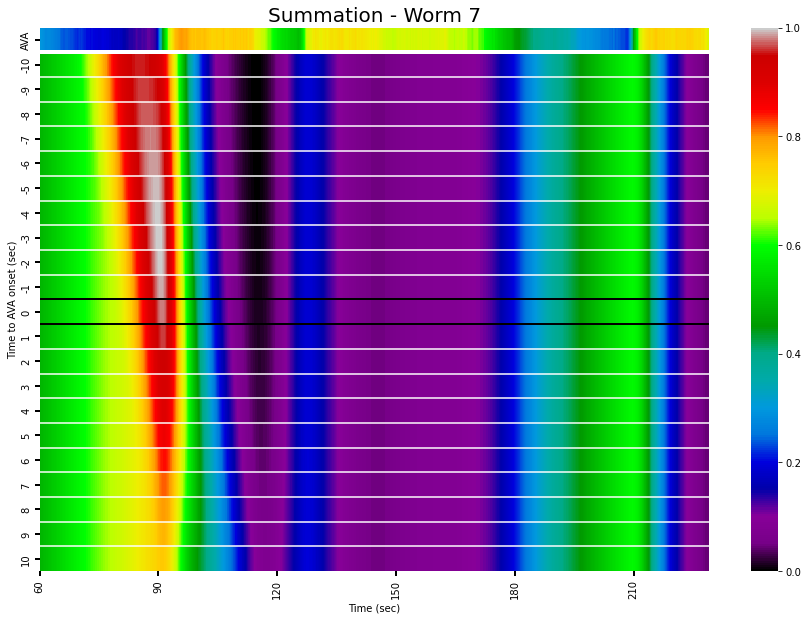

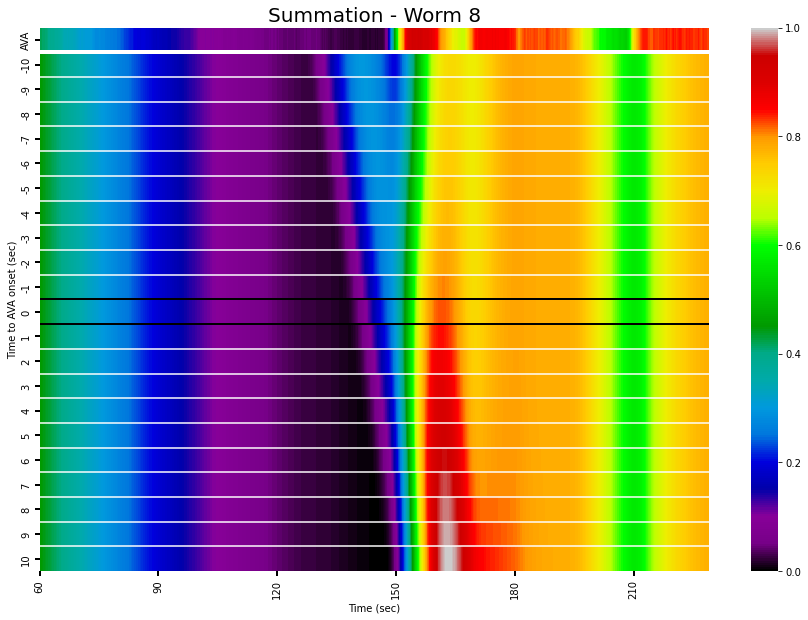

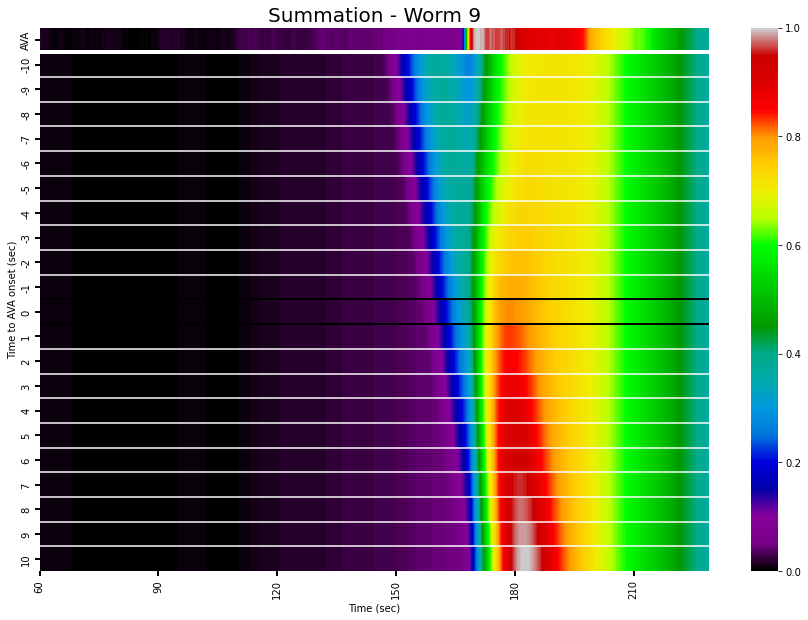

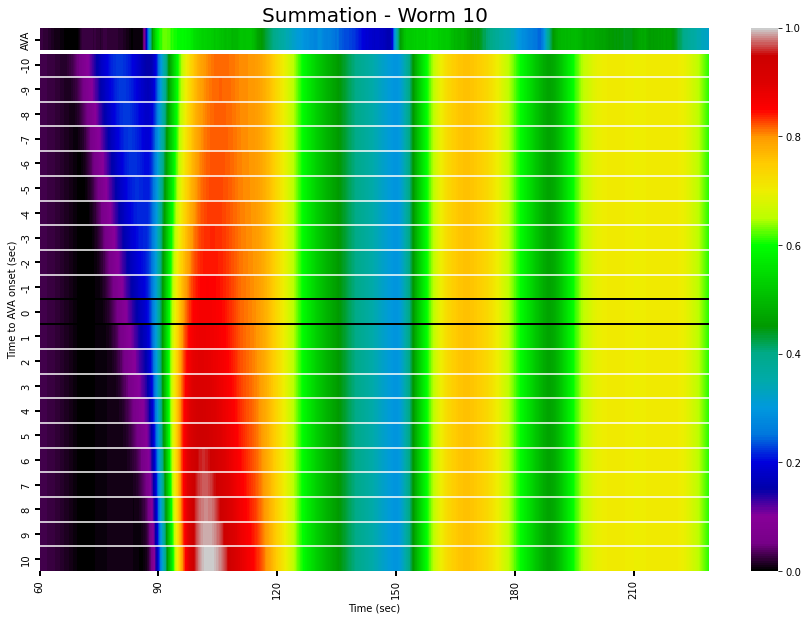

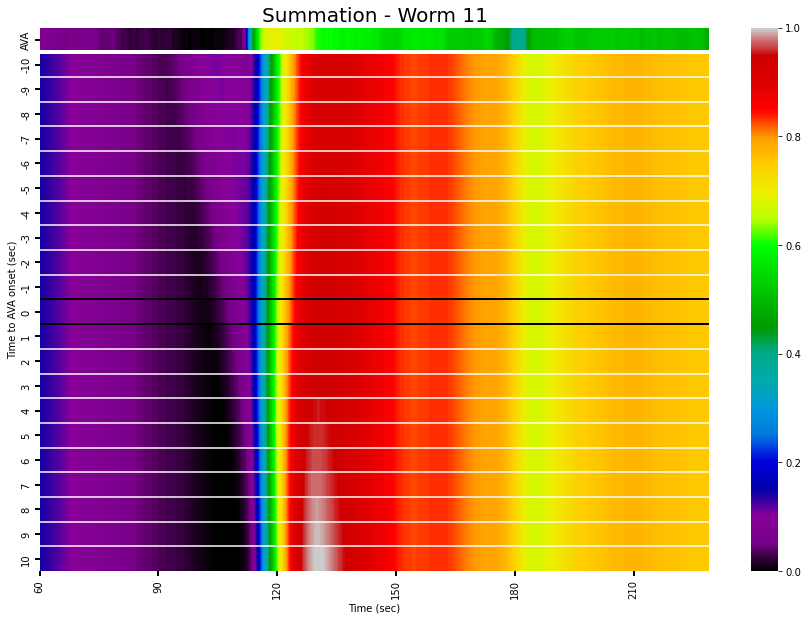

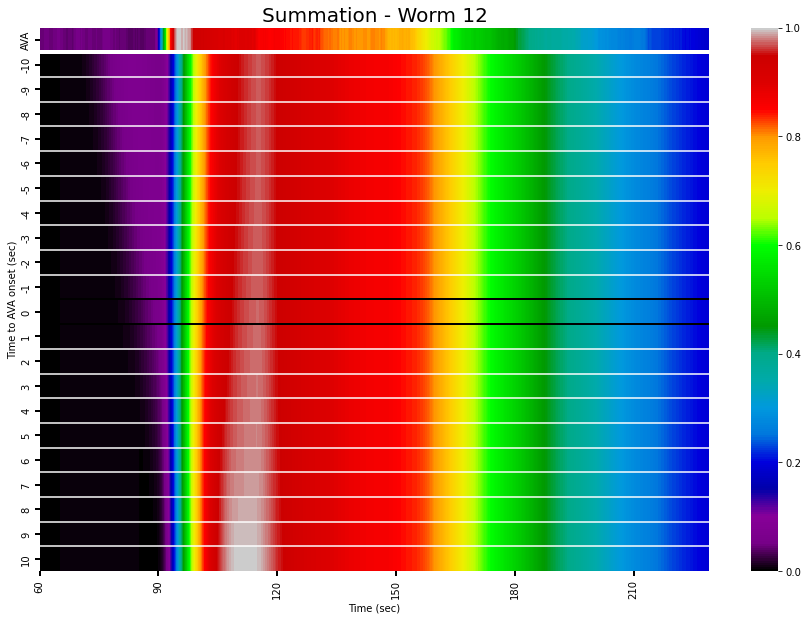

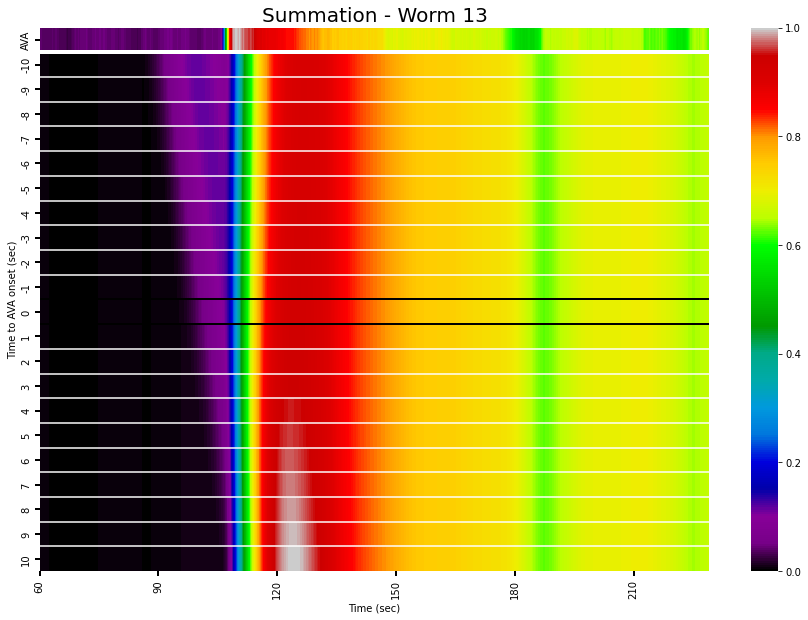

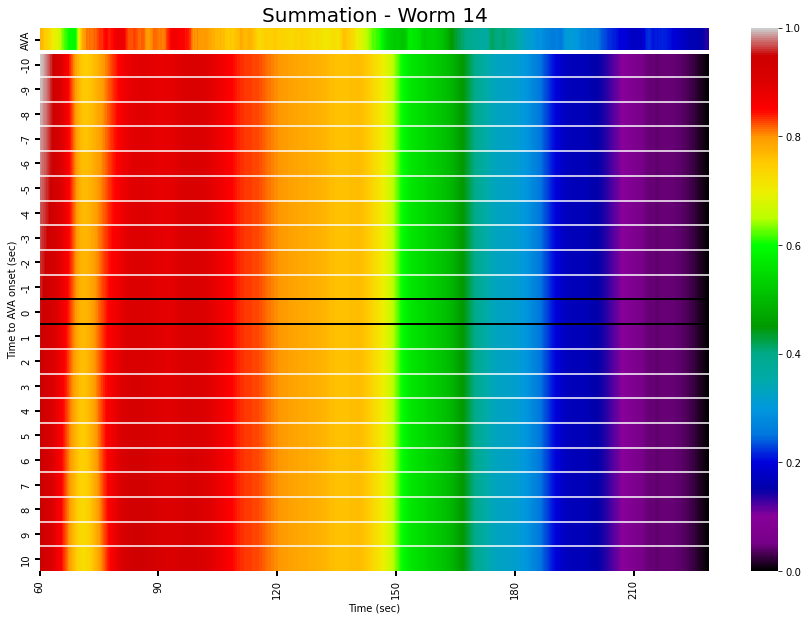

In [16]:
## Plotting Summation Models ##

times_labels_AVA =['AVA'] # the first heatmap on top is AVA, want to label it as such
for i in times:
    sec = i/10 # want time in seconds (10 fps)
    new = str(sec)
    times_labels_AVA.append(new[:-2])

# note for the paper, I have the times labeled relative to AVA onset, 
# which I manually changed in Adobe
# Also, worm #2 is what's displayed in paper
    
for w in range(WT_worm_num): # loop through each worm
    AVA_models = np.concatenate(([WT_AVA_both[w][249:]], normalized_models_grid[w]), axis=0) #modeling truncates data by time-1 (249)
    # want to add normalized AVA trace first so that it can be plotted at the top of each trace
    fig, ax = plt.subplots(1,1, figsize=(15,10), facecolor='w')
    ax.set_title('Summation - Worm ' + str(w), fontsize=20)
    sns.heatmap(AVA_models, cmap = 'nipy_spectral', vmin=0, vmax=1) 
    ax.hlines(np.arange(1,len(times)+1,1), *ax.get_xlim(), color='white') # want to put lines to separate traces
    ax.hlines([11,12], *ax.get_xlim(), color='black', linewidth=2) # highlight time=0 in black
    ax.hlines([1], *ax.get_xlim(), color='white', linewidth=4) # make top line separation thicker for AVA
    ax.set_yticklabels(times_labels_AVA)
    ax.set_xticks(np.arange(0,1800,300))
    ax.set_xticklabels(sec_labels) # using same seconds labels as AWC pulse heatmap
    ax.tick_params(axis= 'both', labelsize=10, length=5, width=2)
    ax.set(xlabel="Time (sec)", ylabel="Time to AVA onset (sec)")
    # note this is time after normalization and modeling, and is reflective of real time
    #plt.savefig('worm' + str(w) + '- Time-shifted AWC Pulses - summation - heatmap.svg')
    

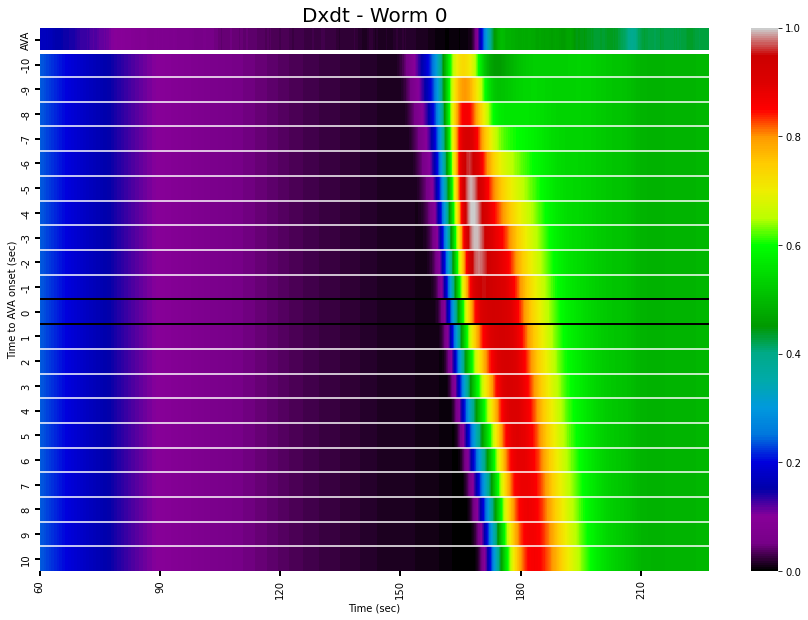

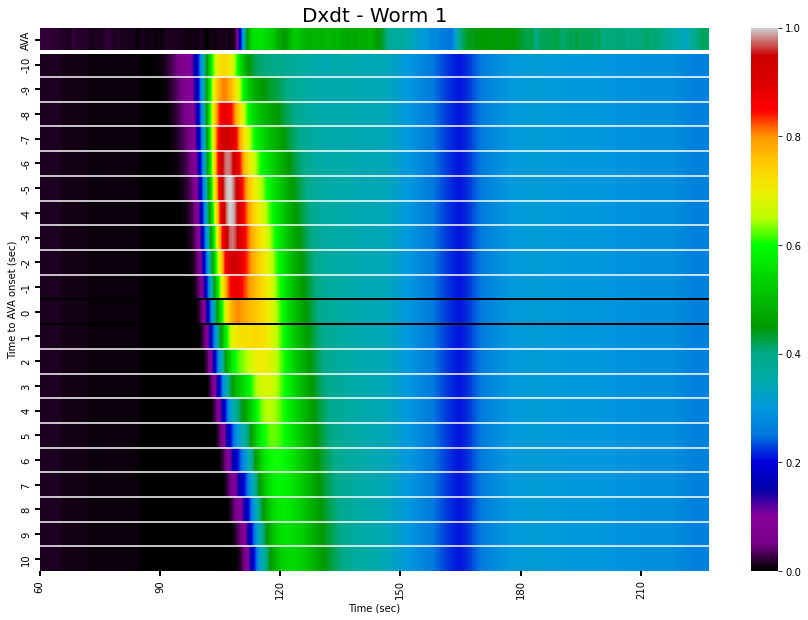

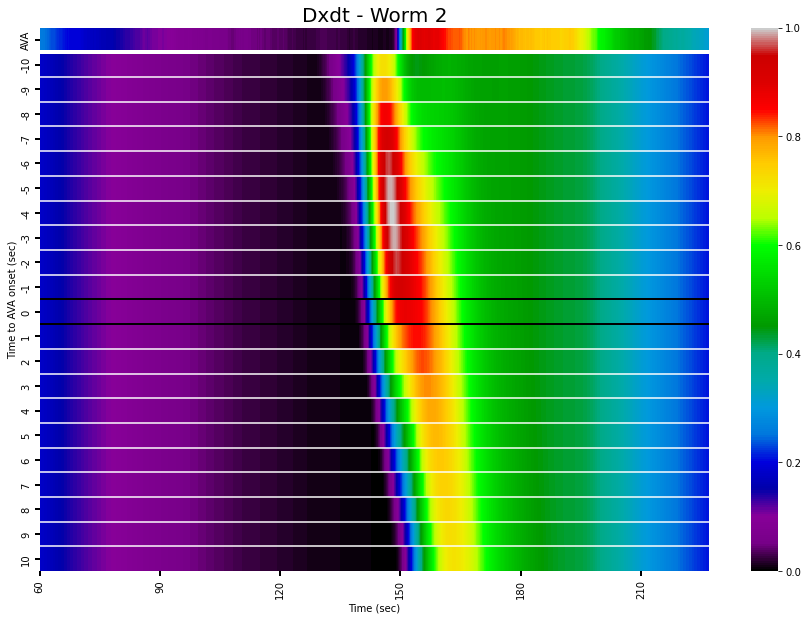

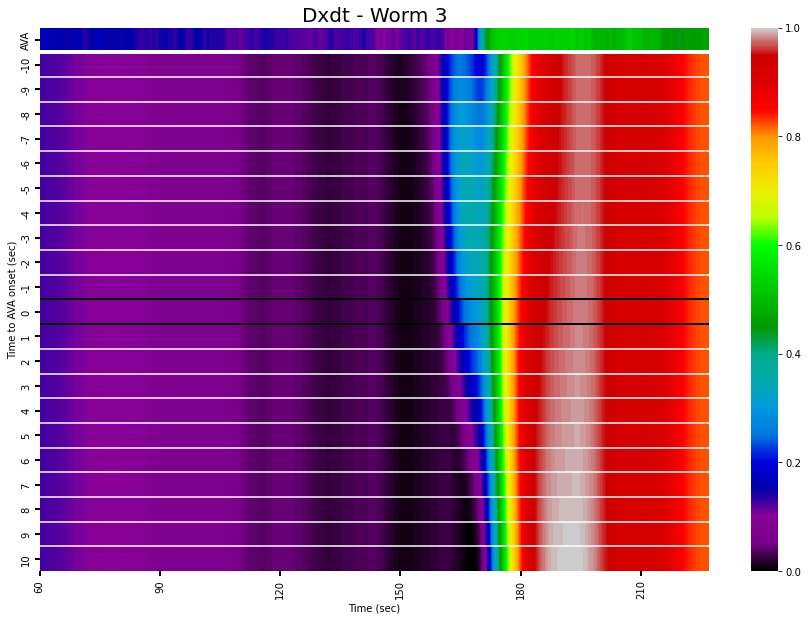

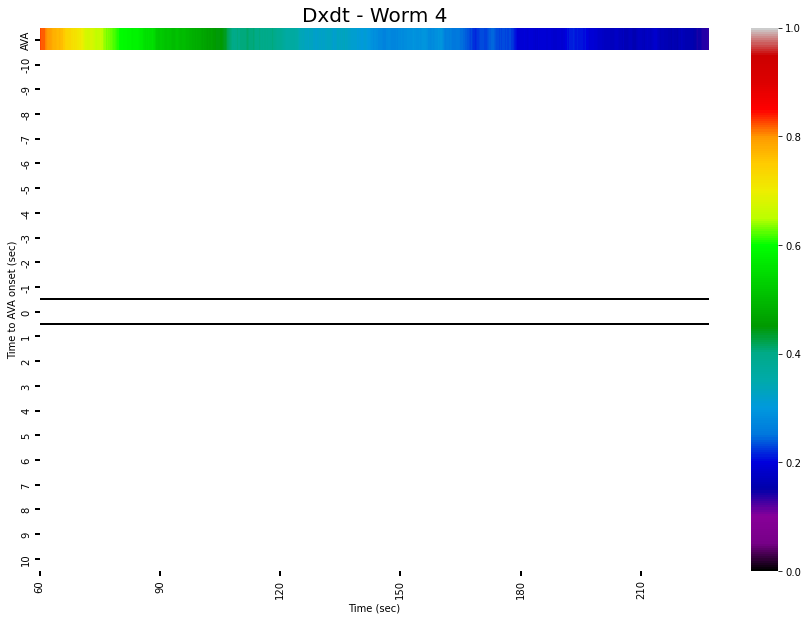

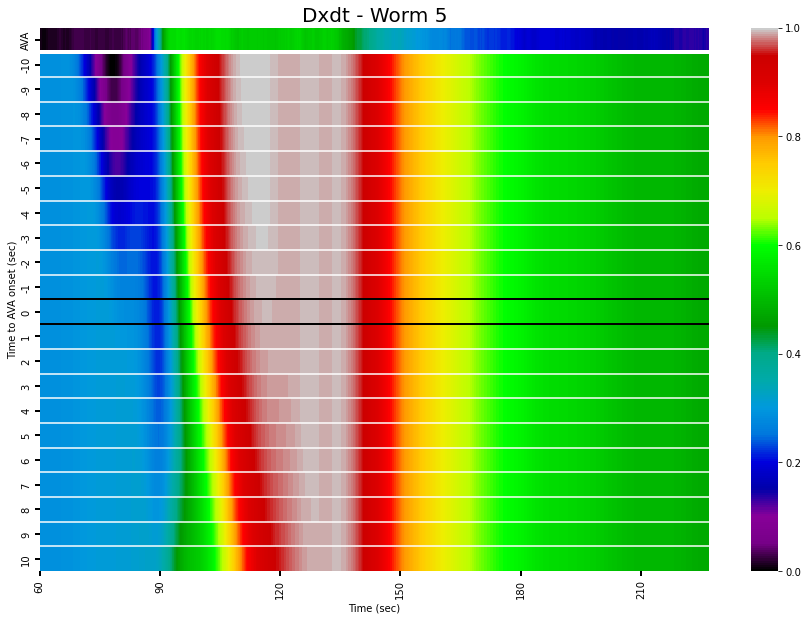

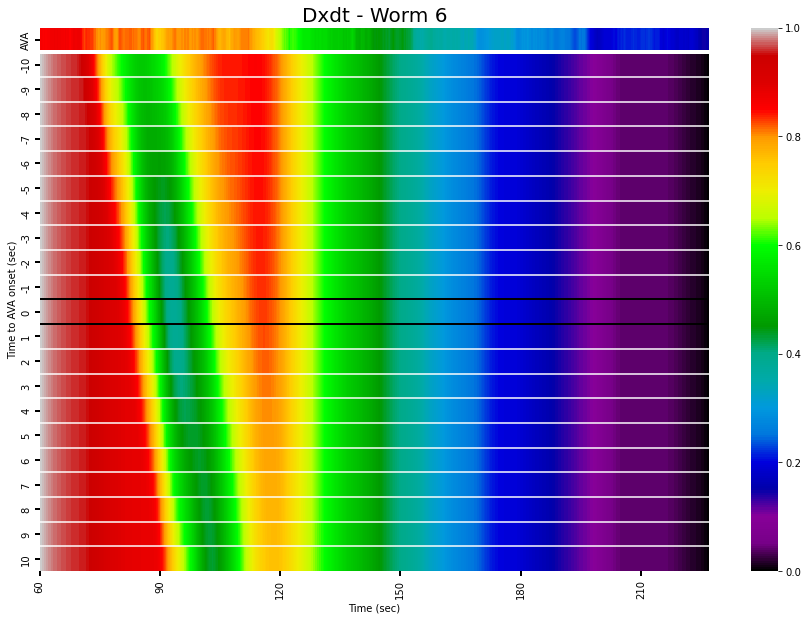

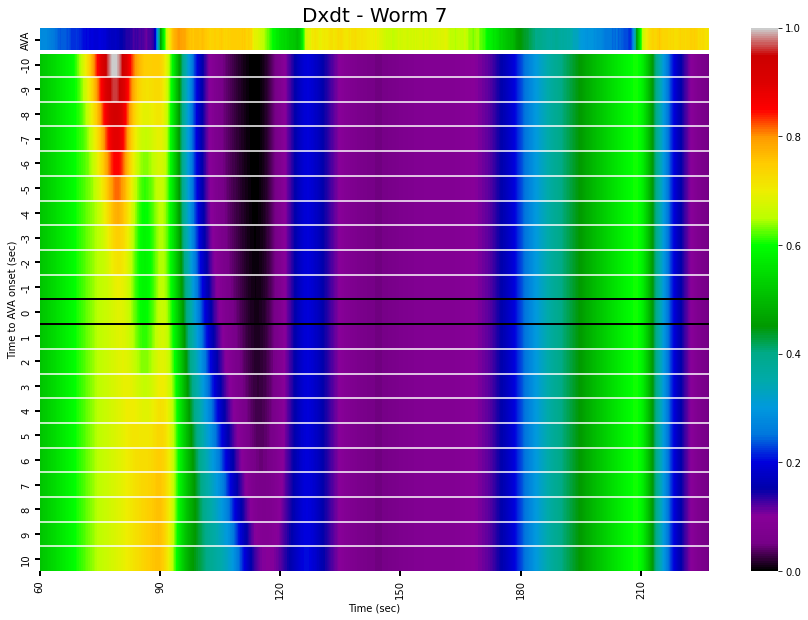

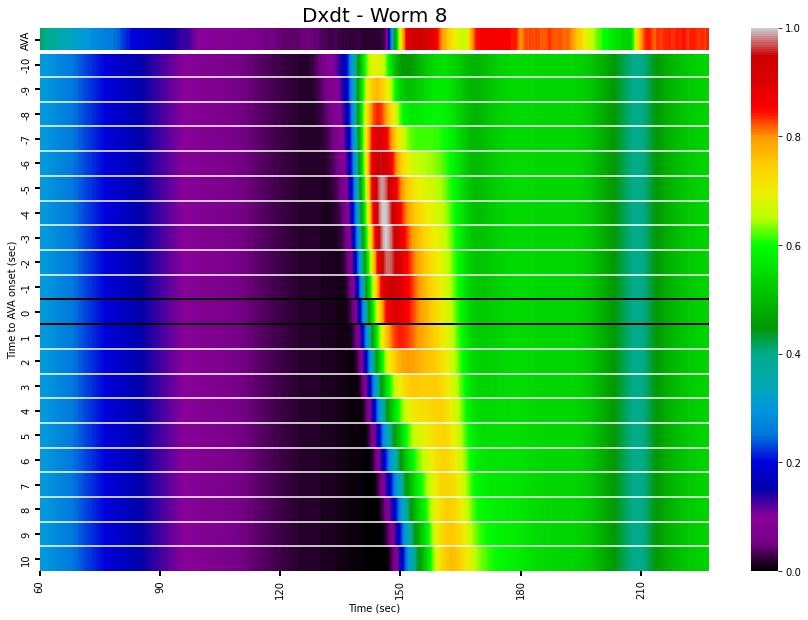

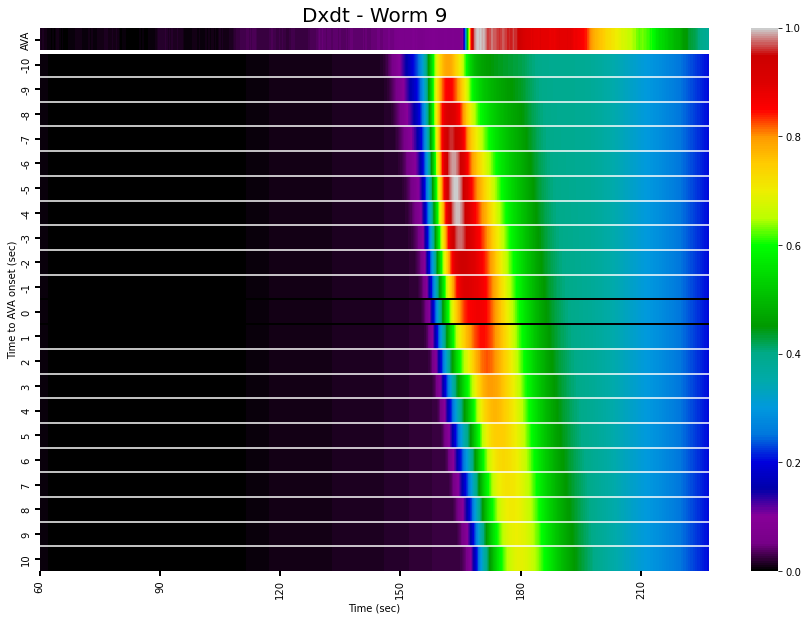

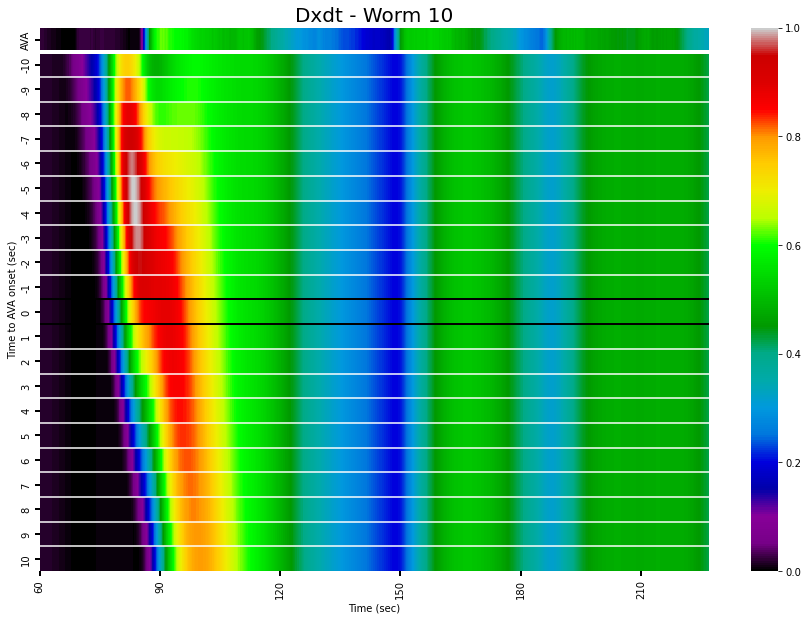

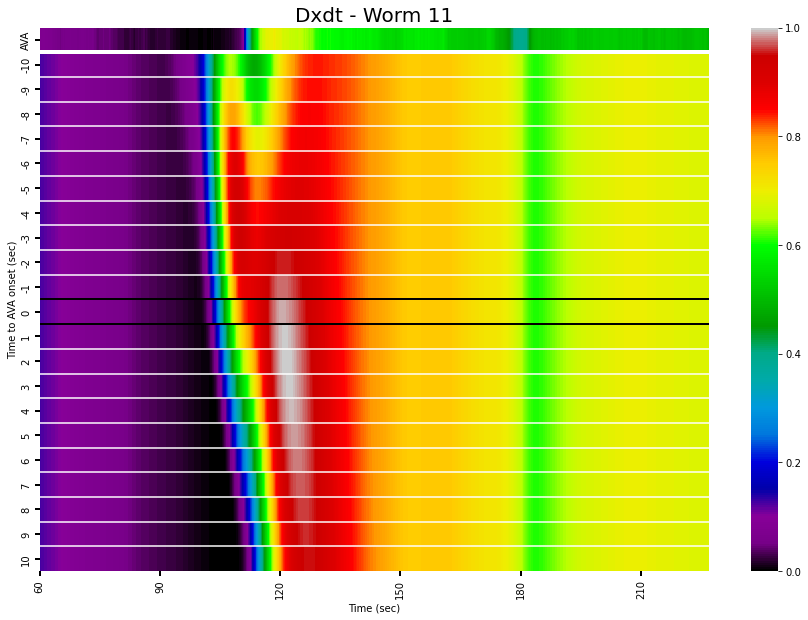

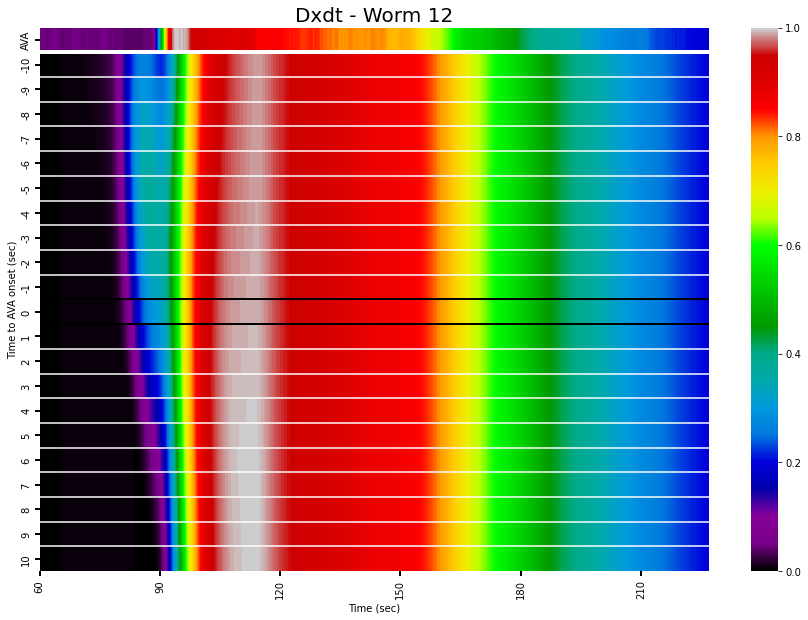

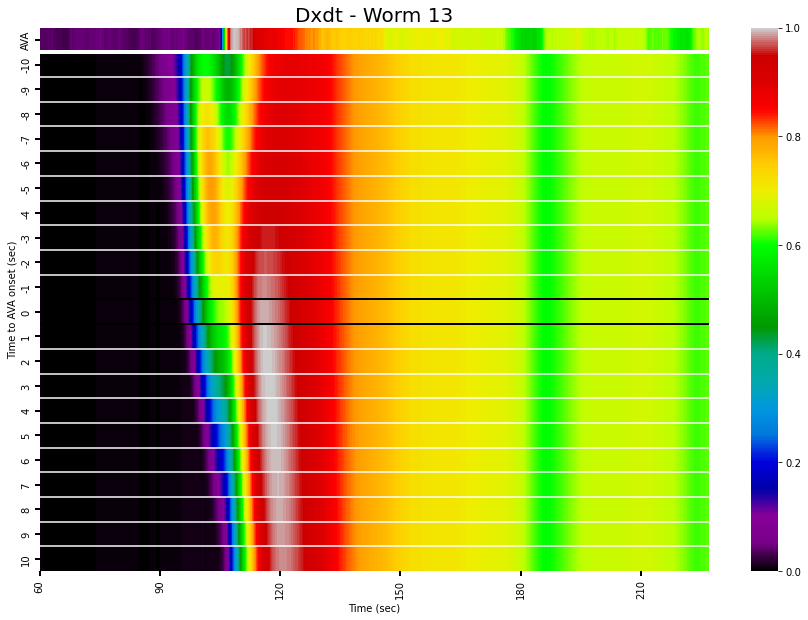

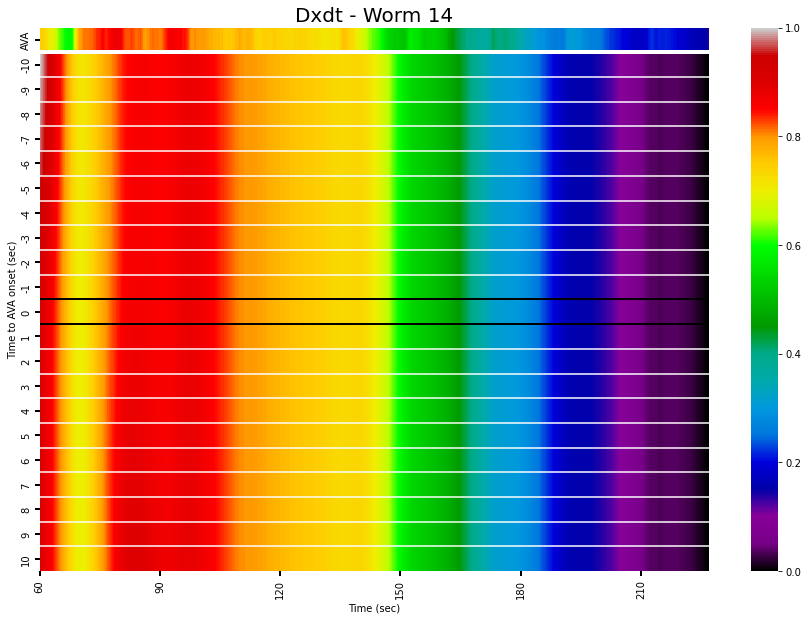

In [17]:
# Plot out Derivative models with time-shifted AWC pulses (same formatting as summation plots above)

# note for the paper, I have the times labeled relative to AVA onset, 
# which I manually changed in Adobe
# Also, worm #2 is what's displayed in paper

for wx in range(WT_worm_num):
    AVA_models = np.concatenate(([WT_AVA_both[wx][259:-10]], normalized_models_grid_dx[wx]), axis=0) # dx truncates data by 10 on both ends
    fig, ax = plt.subplots(1,1, figsize=(15,10), facecolor='w')
    ax.set_title('Dxdt - Worm ' + str(wx), fontsize=20)
    sns.heatmap(AVA_models, cmap = 'nipy_spectral', vmin=0, vmax=1) # see above block for why vmax is 1.5
    ax.hlines(np.arange(1,len(times)+1,1), *ax.get_xlim(), color='white')
    ax.hlines([11,12], *ax.get_xlim(), color='black', linewidth=2)
    ax.hlines([1], *ax.get_xlim(), color='white', linewidth=4)
    ax.set_yticklabels(times_labels_AVA)
    ax.set_xticks(np.arange(0,1800,300))
    ax.set_xticklabels(sec_labels)
    ax.tick_params(axis= 'both', labelsize=10, length=5, width=2)
    ax.set(xlabel="Time (sec)", ylabel="Time to AVA onset (sec)")
    # note this is time after normalization and modeling, and is reflective of real time
    #plt.savefig('worm' + str(wx) + '- Time-shifted AWC Pulses - dxdt - heatmap.svg')
    